In [3]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'

from dataloader import *
from models import load_model
from metrics import *
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
import scipy
import class_names
from utils import *

import json
import urllib
from preprocessing import preprocess_images_any_dataset

/home/davidva/miniconda3/envs/anaconda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
import csv
experiment_list = os.listdir('/home/davidva/experiments_David')
experiment_list.remove('.ipynb_checkpoints')
header_exists_flag = 0  # indicates whether the combined CSV file has a header of "Dataset, Model, Accuracy..."
# print(experiment_list)
with open('/home/davidva/vscode_projects/reliableML/all_experiments_excluding_imagenet_c.csv', 'w') as f:
    wf = csv.writer(f, delimiter = ',')
    for folder in experiment_list:
        results_path = '/home/davidva/experiments_David/' + folder + '/results'
        file_list = os.listdir(results_path)
        end_of_data_name_index = folder.index('_')
        if 'robust' in folder:
            continue
        index = 3 if ('imagenet-a' in folder or 'imagenet-r' in folder) else 2  # making sure that we take the correct file
        # ... in some folders the index of the file is different
        with open(results_path + '/' + file_list[index], mode="r") as csv_file:
            reader = csv.reader(csv_file) #this is the reader object
            line_count = 0
            for row_num, row in enumerate(reader):
                if header_exists_flag == 0 and row_num == 0:
                    header_exists_flag = 1
                    row = ['Dataset', 'Model'] + row
                    wf.writerow(row)
                if row_num == 1:
                    sub_strings = folder.split('_')
                    model_name = sub_strings[2] + '_resnet' if 'wide' in sub_strings[2] else sub_strings[2]
                    data_name = sub_strings[1]
                    row = [data_name, model_name] + row
                    wf.writerow(row)

In [37]:
f = open('/home/davidva/datasets/imagenet_vid_ytbb_robust/imagenet-vid-robust/misc/imagenet_vid_class_index.json')
vid_class_index = json.load(f)
g = open('/home/davidva/datasets/imagenet_vid_ytbb_robust/imagenet-vid-robust/misc/rev_wnid_map.json')
class_name_converter = json.load(g)
ground_truth = str(1)
input_to_class_name_converter = vid_class_index[ground_truth][0]
print(input_to_class_name_converter)
class_name_converter[input_to_class_name_converter]

n02419796


['n02422106', 'n02422699', 'n02423022']

In [34]:
import class_names


h = open('/home/davidva/datasets/imagenet_vid_ytbb_robust/imagenet-vid-robust/misc/wnid_map.json')
wnid_map = json.load(h)

lll = []
for class_name in class_names.all_wnids:
    lll.append(True if class_name in wnid_map.keys() else False)

288

In [28]:
def main():
    # Define device, batch size and directory path for ImageNet validation set
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    base_exp_dir = '/home/davidva/experiments_David'

    # Define the batch size
    batch_size = 128

    # Load imagenet labels as real classes
    imagenet_labels = load_imagenet_labels()  # 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark'...

    data_names = ['imagenetv2-matched-frequency-format-val', 'imagenetv2-threshold0.7-format-val', 'imagenetv2-top-images-format-val', 'imagenetsketch/sketch', 'imagenet-r', 'imagenet-a', 'imagenet']
    data_names = ['imagenet_vid_robust']

    for data_name in data_names:
        if data_name in ['imagenet', 'imagenetv2-matched-frequency-format-val', 'imagenetv2-threshold0.7-format-val', 'imagenetv2-top-images-format-val', 'imagenetsketch']:
            ds_specific_mask = [True] * 1000
            ds_specific_labels = imagenet_labels  # the classes of the specific dataset that we're working with
        elif data_name == 'imagenet-r':
            ds_specific_mask = class_names.imagenet_r_mask
            ds_specific_labels = class_names.imagenet_r_labels
        elif data_name == 'imagenet-a':  # note: if the hidden file .ipynb_checkpoints is inside of the folder of the imagenet-a data,
                                         # it should be removed from there in order to create the DataFolder object
            ds_specific_mask = class_names.imagenet_a_mask
            ds_specific_labels = class_names.imagenet_a_labels
        elif data_name == 'imagenet_vid_robust':
            ds_specific_mask = class_names.imagenet_vid_robust_mask
            ds_specific_labels = class_names.imagenet_vid_robust_labels
            f = open('/home/davidva/datasets/imagenet_vid_ytbb_robust/imagenet-vid-robust/misc/imagenet_vid_class_index.json')
            vid_class_index_to_nid = json.load(f)  # converts class index (between 0 to 29) to imagenet-vid-robust nid (e.g. n029...)
            g = open('/home/davidva/datasets/imagenet_vid_ytbb_robust/imagenet-vid-robust/misc/rev_wnid_map.json')
            class_name_converter = json.load(g)  # converts imagenet-vid-robust nid to a list of imagenet nids
        
        if data_name == 'imagenet':
            val_dir = '/datasets/ImageNet/val/'
        elif data_name == 'imagenetsketch':
            val_dir = '/home/davidva/datasets/imagenetsketch/sketch'
        elif data_name == 'imagenet_vid_robust':
            val_dir = '/home/davidva/datasets/imagenet_vid_ytbb_robust/imagenet-vid-robust/val'
        else:
            val_dir = '/home/davidva/datasets/' + data_name
        print('data_name is: ' + data_name + ' and val_dir is: ' + val_dir)

        model_names = ['resnet50']
    
        for model_name in model_names:
            # Experiment name
            curr_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
            exp_base_name = 'predict_' + data_name + '_' + model_name
            exp_name = exp_base_name + '_' + curr_time
            exp_dir = os.path.join(base_exp_dir, exp_name)
            results_dir = os.path.join(exp_dir, 'results')
            embed_dir = os.path.join(results_dir, 'val_embeddings')
        
            # Create experiment directory
            os.makedirs(exp_dir, exist_ok=True)
            os.makedirs(results_dir, exist_ok=True)
            os.makedirs(embed_dir, exist_ok=True)
                
            # Load the ImageNet validation dataset with defined transformations
            val_dataset = ImageFolder(val_dir, transform=preprocess_images_any_dataset(model_name))
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=5)
    
            # Load model
            model = load_model(model_name).to(device)
            model.eval()
            
            # Register the hook at the penultimate layer of the model
            if model_name in ['mobilenet_v2']:
                layer = model.classifier[0]
            elif model_name in ['densenet121']:
                layer = model.features   # model.features.norm5 sucks, features.denseblock3.denselayer24 is okay, features gives 1000-of-shape output, model.features.denseblock3.denselayer24.conv2 is okay
            elif model_name in ['vgg16', 'vgg19']:
                layer = model.classifier[-2]
            else:
                layer = model.avgpool
            
            # Prepare DataFrame to store results
            results = []
            total_correct = 0
            batch_num = 0
            all_entropies = np.empty([0])
            all_means = np.empty([0])
            all_variances = np.empty([0])
            all_skewnesses = np.empty([0])
            all_kurtosises = np.empty([0])
            all_top5_entropies = np.empty([0])
            all_top5_means = np.empty([0])
            all_top5_variances = np.empty([0])
            all_top5_skewnesses = np.empty([0])
            all_top5_kurtosises = np.empty([0])
    
            # Disable gradients for faster inference
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(tqdm(val_loader, desc=f"Processing {exp_name}")):
                    images = images.to(device)
                    labels = labels.to(device)
    
                    handle = layer.register_forward_hook(get_embedding_hook(batch_idx, batch_size, embed_dir))
    
                    # Run forward pass through the model and calculate probabilities
                    output = model(images)

                    # Create a tensor of the mask on the device
                    mask_tensor = torch.tensor(ds_specific_mask).to(device)

                    # Replace masked values in the output with negative infinity
                    if data_name in ['imagenet-a', 'imagenet-r', 'imagenet_vid_robust']:
                        output[:, ~mask_tensor] = float('-inf')

                    # Apply softmax
                    probabilities = torch.nn.functional.softmax(output, dim=1)
                    
                    # Get top-5 predictions and confidences and some statistics
                    top5_prob, top5_classes = torch.topk(probabilities, 5)
                    _, _, top5_means, top5_variances, top5_skewnesses, top5_kurtosises = scipy.stats.describe(top5_prob.detach().cpu().numpy() , axis=1)
                    all_top5_means = np.concatenate((all_top5_means, top5_means))
                    all_top5_variances = np.concatenate((all_top5_variances, top5_variances))
                    all_top5_skewnesses = np.concatenate((all_top5_skewnesses, top5_skewnesses))
                    all_top5_kurtosises = np.concatenate((all_top5_kurtosises, top5_kurtosises))
                    top5_entropies = scipy.stats.entropy(top5_prob.detach().cpu().numpy(), axis=1)
                    all_top5_entropies = np.concatenate((all_top5_entropies, top5_entropies))
                    
                    _, _, means, variances, skewnesses, kurtosises = scipy.stats.describe(probabilities.detach().cpu().numpy() , axis=1)
                    all_means = np.concatenate((all_means, means))
                    all_variances = np.concatenate((all_variances, variances))
                    all_skewnesses = np.concatenate((all_skewnesses, skewnesses))
                    all_kurtosises = np.concatenate((all_kurtosises, kurtosises))
                    entropies = scipy.stats.entropy(probabilities.detach().cpu().numpy(), axis=1)
                    all_entropies = np.concatenate((all_entropies, entropies))
        
                    # Iterate over each image in the batch
                    for i in range(len(images)):
                        image_idx = batch_idx * batch_size + i
                        image_path = val_dataset.imgs[i + batch_num * batch_size][0]
                        # true_class = val_dataset.classes[labels[i].item()]
                        true_class = ds_specific_labels[labels[i].item()]  # e.g. labels[i].item()=0. true_class=goldfish
                        predictions = {"image_path": image_path,
                                       "true_class": true_class,
                                       "embeddings_path":  os.path.join(embed_dir, f"{image_idx}_embeddings.npy")}
                        
                        for j in range(5):
                            # predictions[f"top{j+1}_prediction_class"] = val_dataset.classes[top5_classes[i, j].item()]
                            prediction_class = imagenet_labels[top5_classes[i, j].item()]
                            predictions[f"top{j+1}_prediction_class"] = prediction_class
                            predictions[f"top{j+1}_confidence"] = top5_prob[i, j].item()

                            # Check if top-1 prediction is correct
                            if data_name == 'imagenet_vid_robust':
                                if j == 0:
                                    prediction_class = class_names.all_wnids[top5_classes[i, j].item()]
                                    vid_robust_class_nid = vid_class_index_to_nid[str(labels[i].item())][0]  # e.g. 'n02419796'
                                    ground_truth_classes = class_name_converter[vid_robust_class_nid] # e.g. ['n02422106', 'n02422699', 'n02423022']
                                    if prediction_class in ground_truth_classes:
                                        total_correct += 1
                            elif j == 0 and prediction_class == true_class:
                                total_correct += 1
                        results.append(predictions)
                    batch_num += 1
                    handle.remove()  # Unregister the hook after processing the batch                                
            
            # Convert results to DataFrame and save to CSV
            results_df = pd.DataFrame(results)
            results_df.to_csv(os.path.join(results_dir, f"full_val_predictions_{exp_base_name}.csv"), index=False)
        
            # Calculate average and std of the top1 confidences across the val set2
            avg_confidence = results_df["top1_confidence"].mean()
            std_confidence = results_df["top1_confidence"].std()
            accuracy = total_correct / len(val_dataset)
            average_top5_mean = np.mean(all_top5_means)
            average_top5_variance = np.mean(all_top5_variances)
            average_top5_skewness = np.mean(all_top5_skewnesses)
            average_top5_kurtosis = np.mean(all_top5_kurtosises)
            average_top5_entropy = np.mean(all_top5_entropies)
            average_mean = np.mean(all_means)
            average_variance = np.mean(all_variances)
            average_skewness = np.mean(all_skewnesses)
            average_kurtosis = np.mean(all_kurtosises)
            average_entropy = np.mean(all_entropies)
            top2_grad_confidence = (results_df["top1_confidence"] - results_df["top2_confidence"]).mean()
    
            # Save average and std confidences in a new DataFrame and some more statistics
            confidence_df = pd.DataFrame({
                "Accuracy": [accuracy],
                "Average Confidence": [avg_confidence],
                "Standard Deviation Confidence": [std_confidence],
                "Average Entropy": [average_entropy],
                "Average mean": [average_mean],
                "Average variance": [average_variance],
                "Average skewness": [average_skewness],
                "Average kurtosis": [average_kurtosis],
                "Average top5 Entropy": [average_top5_entropy],
                "Average top5 mean": [average_top5_mean],
                "Average top5 variance": [average_top5_variance],
                "Average top5 skewness": [average_top5_skewness],
                "Average top5 kurtosis": [average_top5_kurtosis],
                "top2_grad_confidence": [top2_grad_confidence]
            })
            confidence_df.to_csv(os.path.join(results_dir, f"val_confidence_summary_{exp_base_name}.csv"), index=False)
    
            # Handle embeddings
            embeddings = np.array([np.load(file) for file in results_df['embeddings_path']])
            # assuming embeddings is a 4D numpy array
            embeddings = embeddings.reshape(embeddings.shape[0], -1)
            break
            average, covariance = calculate_activation_statistics(embeddings)
            np.save(os.path.join(results_dir, 'embeddings_covariance.npy'), covariance)
            np.save(os.path.join(results_dir, 'embeddings_average.npy'), average)
            # np.save(os.path.join(results_dir, 'tot_embeddings_2D_np_array.npy'), embeddings)
            
            # Create a new DataFrame for embeddings
            # df_embeddings = pd.DataFrame(*******, columns=np.arange(0, embeddings.shape[1]))
            # df_embeddings['true_class'] = results_df['true_class']
            # df_embeddings['predicted_class'] = results_df['top1_prediction_class']
            # df_embeddings['image_path'] = results_df['image_path']
            # # Save as CSV
            # df_embeddings.to_csv(os.path.join(results_dir, f"val_embeddings_2d_{exp_base_name}.csv"), index=False)

In [29]:
if __name__ == '__main__':
    main()

data_name is: imagenet_vid_robust and val_dir is: /home/davidva/datasets/imagenet_vid_ytbb_robust/imagenet-vid-robust/val


/home/davidva/miniconda3/envs/anaconda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Processing predict_imagenet_vid_robust_resnet50_25-07-2023_00-11-20: 100%|█| 77/77 [01:40<00:00,  1.


R2_score: 0.6501112694534414
Pearson correlation coefficient: 0.8062947782625419


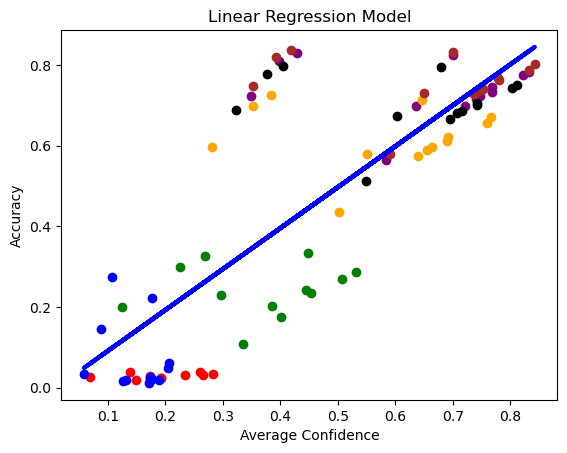

R2_score: 4.997386303218221e-06
Pearson correlation coefficient: -0.0022354834606667096


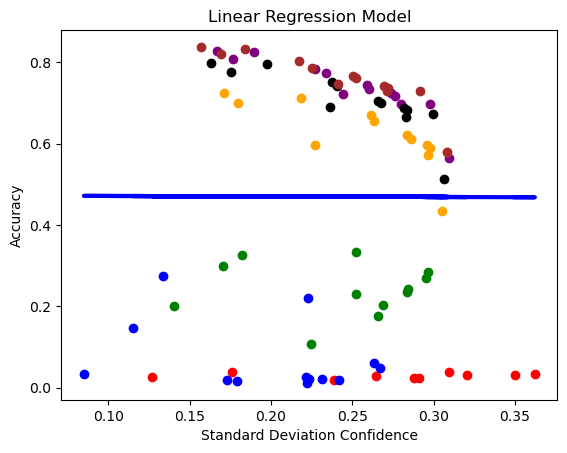

R2_score: 0.03693766740904969
Pearson correlation coefficient: -0.19219174646443477


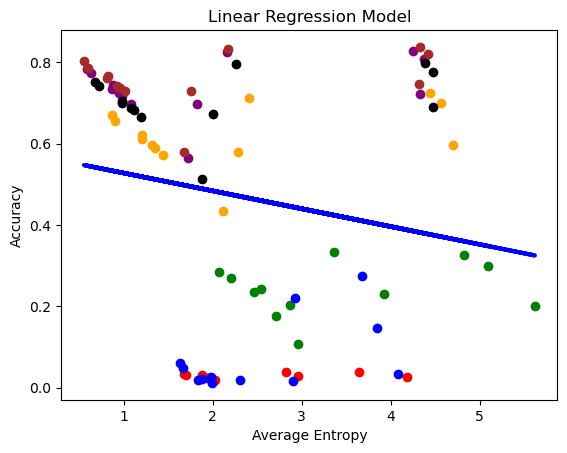

R2_score: 0.6704789457563163
Pearson correlation coefficient: 0.8188277876063539


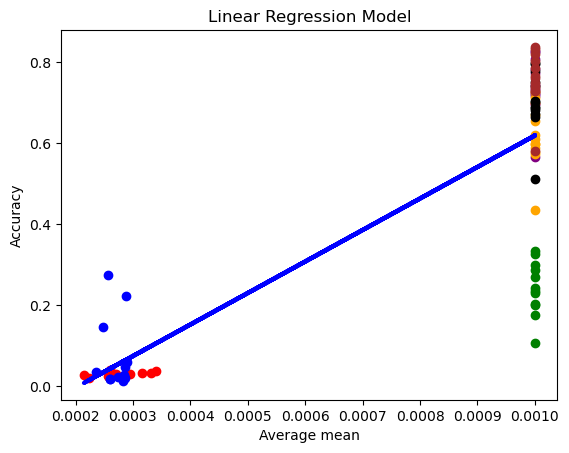

R2_score: 0.5263055404990891
Pearson correlation coefficient: 0.7254691864573499


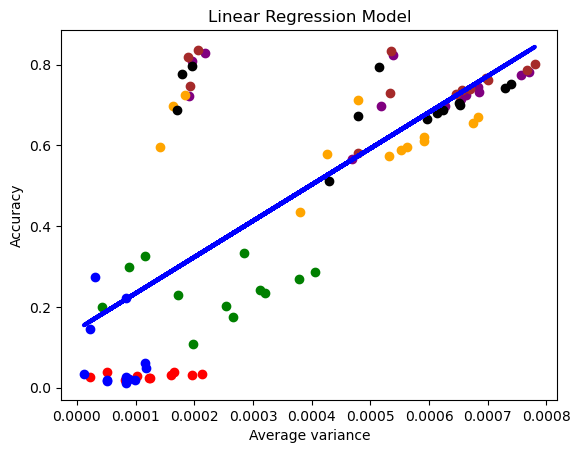

R2_score: 0.6567994036750466
Pearson correlation coefficient: 0.8104316156684945


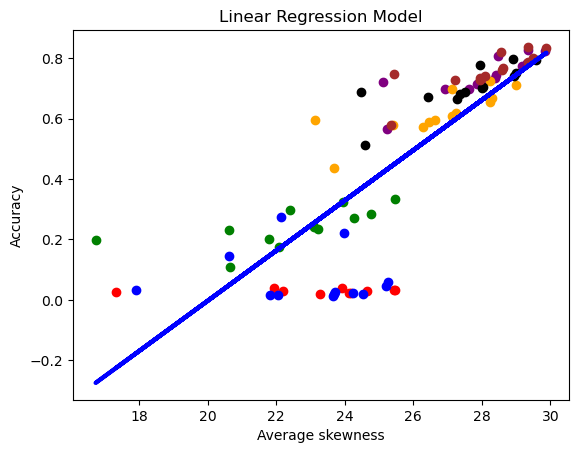

R2_score: 0.7032752150189865
Pearson correlation coefficient: 0.83861505771062


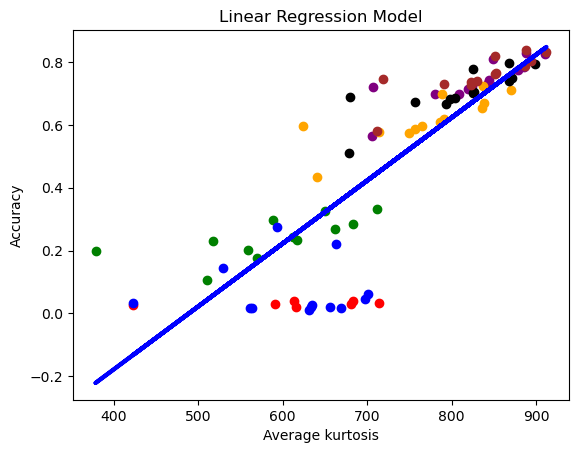

R2_score: 0.6886024160187326
Pearson correlation coefficient: -0.8298207131776916


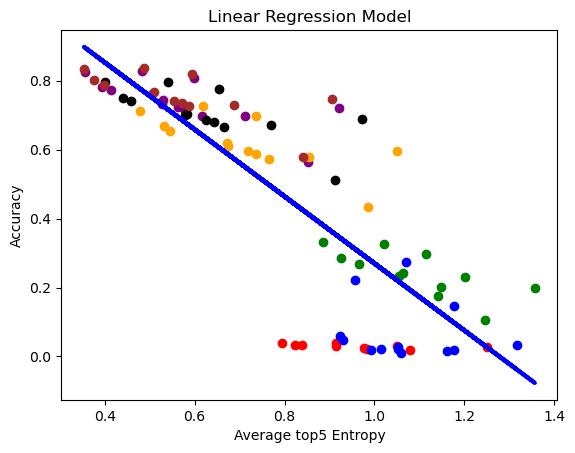

R2_score: 0.5831856766207472
Pearson correlation coefficient: 0.7636659456992613


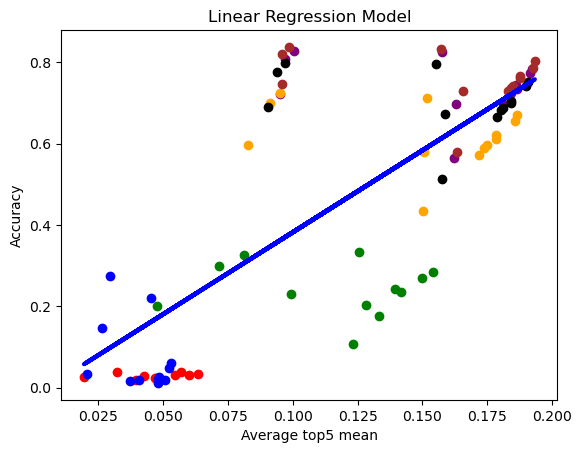

R2_score: 0.5340811888329794
Pearson correlation coefficient: 0.7308085856316819


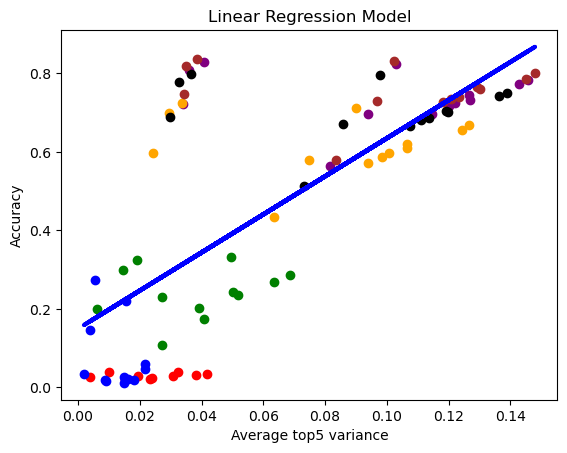

R2_score: 0.711007369775133
Pearson correlation coefficient: 0.8432125294225252


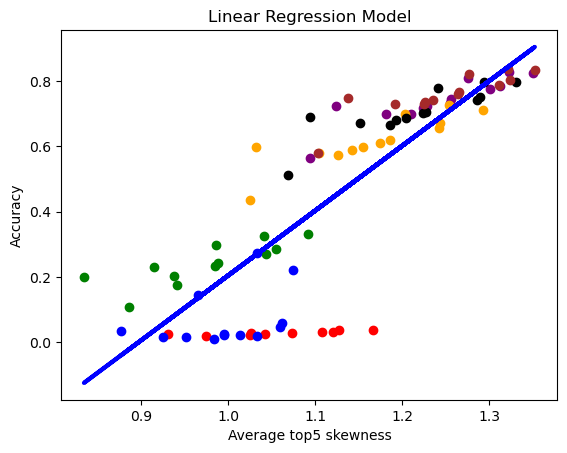

R2_score: 0.7326678409871612
Pearson correlation coefficient: 0.855960186566619


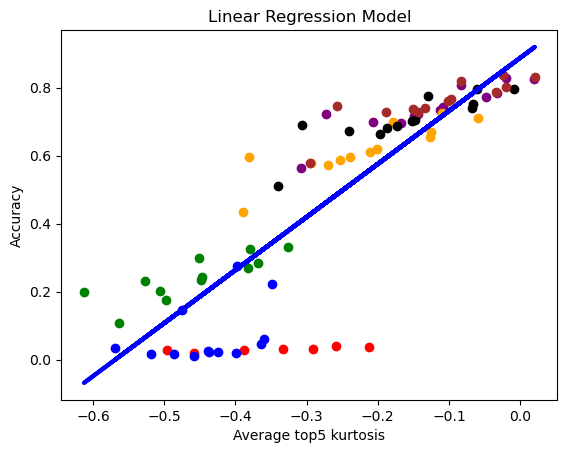

R2_score: 0.6681631608973131
Pearson correlation coefficient: 0.8174124790442785


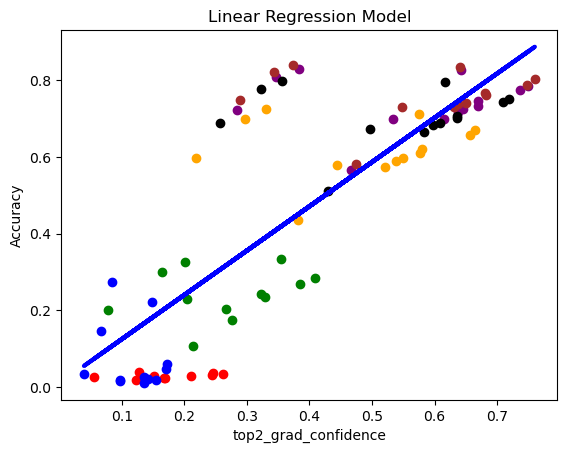

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy

df = pd.read_csv('all_experiments.csv')
datasets = df['Dataset'].unique()  # list of dataset names

# colors for the scatter plot. each dataset gets a different color
colors = ['red', 'green', 'blue', 'purple', 'orange', 'black', 'brown']

for column in df.columns[3:]:  # skipping the first three columns where there aren't any response vectors
    X = df[column].values.reshape(-1, 1)
    y = df['Accuracy'].values.reshape(-1, 1)
    nan_mask = np.isnan(X)  # used for the case of the kurtosis column where there are some rows without values
    if np.sum(nan_mask > 0):
        X = X[~nan_mask].reshape(-1, 1)
        y = y[~nan_mask].reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    
    R2_score = r2_score(y, y_pred)
    print('R2_score: ' + str(R2_score))
    pearson_correlation_coeff = scipy.stats.pearsonr(X.flatten(), y.flatten()).statistic
    print('Pearson correlation coefficient: ' + str(pearson_correlation_coeff))
    
    plt.plot(X, y_pred, color='blue', linewidth=3)
    
    for i, dataset in enumerate(datasets):
        X = df[df['Dataset'] == dataset][column].values.reshape(-1, 1)
        y = df[df['Dataset'] == dataset]['Accuracy'].values.reshape(-1, 1)
        plt.scatter(X, y, color=colors[i], label=dataset)
    
    plt.title('Linear Regression Model')
    plt.xlabel(column)
    plt.ylabel('Accuracy')
    
    plt.show()

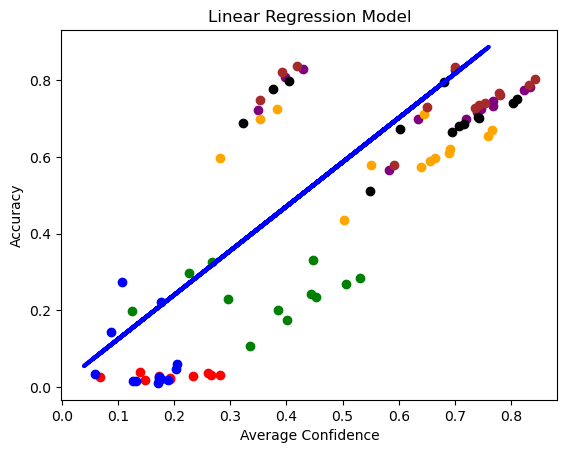

In [68]:
import matplotlib.pyplot as plt

df = pd.read_csv('all_experiments.csv')

datasets = df['Dataset'].unique()

colors = ['red', 'green', 'blue', 'purple', 'orange', 'black', 'brown']

X = df[column].values.reshape(-1, 1)
y = df['Accuracy'].values.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
plt.plot(X, reg.predict(X), color='blue', linewidth=3)

for i, dataset in enumerate(datasets):
    X = df[df['Dataset'] == dataset]['Average Confidence'].values.reshape(-1, 1)
    y = df[df['Dataset'] == dataset]['Accuracy'].values.reshape(-1, 1)
    plt.scatter(X, y, color=colors[i], label=dataset)

plt.title('Linear Regression Model')
plt.xlabel('Average Confidence')
plt.ylabel('Accuracy')

# plt.legend()

plt.show()

In [2]:
datasets

array(['imagenet-r', 'imagenetsketch', 'imagenet-a', 'imagenet',
       'imagenetv2-matched-frequency-format-val',
       'imagenetv2-threshold0.7-format-val',
       'imagenetv2-top-images-format-val'], dtype=object)

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy

df = pd.read_csv('all_experiments.csv')
datasets = df['Dataset'].unique()  # list of dataset names
df[df['Dataset'] != 'imagenet']['Accuracy'].values.reshape(-1, 1)

datasets = df['Dataset'].unique()
models = df['Model'].unique()

df[df['Dataset'] == 'imagenet'][2:] - df[df['Dataset'] == 'imagenetsketch'][2:]

for i, dataset in enumerate(datasets):
    X = df[df['Dataset'] == dataset]['Average Confidence'].values.reshape(-1, 1)
    y = df[df['Dataset'] == dataset]['Accuracy'].values.reshape(-1, 1)
    plt.scatter(X, y, color=colors[i], label=dataset)

Dataset      Model  Accuracy  Average Confidence  \
0       imagenet-r  resnet101  0.032033            0.265867   
1       imagenet-r  resnet152  0.033133            0.282314   
2       imagenet-r      vgg16  0.022700            0.192106   
3       imagenet-r      vgg19  0.024333            0.193008   
4   imagenetsketch    alexnet  0.107190            0.335386   
..             ...        ...       ...                 ...   
82  imagenetsketch   resnet18  0.202275            0.385024   
83  imagenetsketch   resnet34  0.234717            0.453465   
84  imagenetsketch  resnet101  0.269674            0.506534   
85  imagenetsketch  resnet152  0.285335            0.531671   
86  imagenetsketch      vgg16  0.175316            0.400317   

    Standard Deviation Confidence  Average Entropy  Average mean  \
0                        0.349879         1.698096      0.000316   
1                        0.362131         1.683352      0.000332   
2                        0.287955         1.938001      0.000259   
3                        0.291128         1.950849      0.000257   
4                        0.224729         2.956662      0.001000   
..                            ...              ...           ...   
82                       0.268942         2.872674      0.001000   
83                       0.283529         2.465972      0.001000   
84                       0.295028         2.205998      0.001000   
85                       0.296610         2.076979      0.001000   
86                       0.265989         2.709950      0.001000   

    Average variance  Average skewness  Average kurtosis  \
0           0.000196         25.439333        714.420091   
1           0.000214         25.454515               NaN   
2           0.000123         24.125263               NaN   
3           0.000125         24.173059               NaN   
4           0.000198         20.650934        509.929417   
..               ...               ...               ...   
82          0.000253         21.797509        559.519886   
83          0.000321         23.206826        616.933145   
84          0.000378         24.261559        661.885305   
85          0.000405         24.774647        682.860920   
86          0.000266         22.083484        570.110616   

    Average top5 Entropy  Average top5 mean  Average top5 variance  \
0               0.837956           0.060039               0.038104   
1               0.822750           0.063252               0.041642   
2               0.983810           0.047117               0.023421   
3               0.976773           0.046889               0.023870   
4               1.245299           0.123210               0.027329   
..                   ...                ...                    ...   
82              1.149213           0.128144               0.039099   
83              1.055549           0.141902               0.051717   
84              0.965772           0.149819               0.063332   
85              0.925970           0.154008               0.068716   
86              1.140824           0.133331               0.040764   

    Average top5 skewness  Average top5 kurtosis  top2_grad_confidence  
0                1.107912              -0.291010              0.244674  
1                1.119792                    NaN              0.261187  
2                1.025177                    NaN              0.167419  
3                1.041962                    NaN              0.169345  
4                0.885319              -0.562983              0.213054  
..                    ...                    ...                   ...  
82               0.937191              -0.505784              0.266668  
83               0.985012              -0.447728              0.329656  
84               1.042754              -0.382257              0.384327  
85               1.054964              -0.368010              0.409205  
86               0.940617              -0.497814              0.276829  

In [169]:
df = pd.read_csv('all_experiments_excluding_imagenet_c.csv')
datasets = df['Dataset'].unique()  # list of dataset names
models = df['Model'].unique()  # list of dataset names

for dataset in datasets:
    if dataset in ['imagenet', 'imagenet_with_labels_of_imagenet-r', 'imagenet_with_labels_of_imagenet-a']:
        continue
    for model in models:
        for i, col in enumerate(list(df.columns[2:])):
            shifted_col = i + 2
            ID_dataset_name = 'imagenet_with_labels_of_' + dataset if dataset in ['imagenet_with_labels_of_imagenet-r', 'imagenet_with_labels_of_imagenet-a'] else 'imagenet'
            # the line of the data of a specific OOD dataset and a specific model
            ID_value = df[(df['Dataset'] == ID_dataset_name) & (df['Model'] == model)].iloc[:, shifted_col].to_numpy()
            # the line of the data of a imagenet and a specific model
            OOD_value = df[(df['Dataset'] == dataset) & (df['Model'] == model)].iloc[:, shifted_col].to_numpy()
            # subtracting between the lines
            diff = ID_value - OOD_value
            # assigning the values to the line of OOD dataset
            df.loc[(df['Dataset'] == dataset) & (df['Model'] == model), df.columns[shifted_col]] = diff
df = df[(df['Dataset'] != 'imagenet') & (df['Dataset'] != 'imagenet_with_labels_of_imagenet-a') & (df['Dataset'] != 'imagenet_with_labels_of_imagenet-r')]

df.to_csv(path_or_buf = "all_experiments_excluding_imagenet_c_differences.csv")

R2_score: 0.9267620768830235
Pearson correlation coefficient: 0.9626848273879793


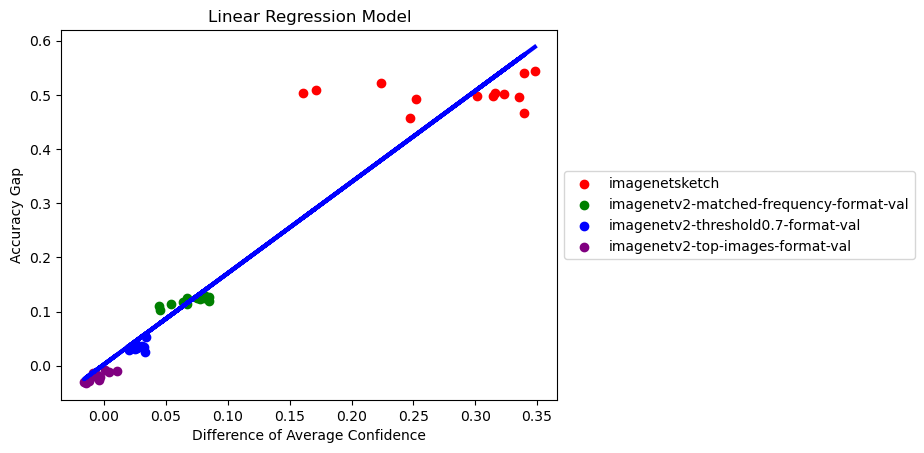

R2_score: 3.1412764628591106e-05
Pearson correlation coefficient: -0.005604709147569581


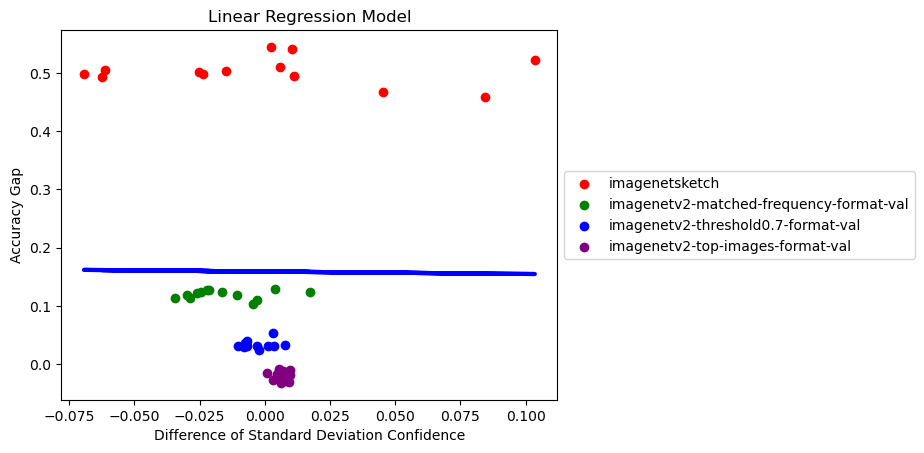

R2_score: 0.8792660700363265
Pearson correlation coefficient: -0.9376918843822455


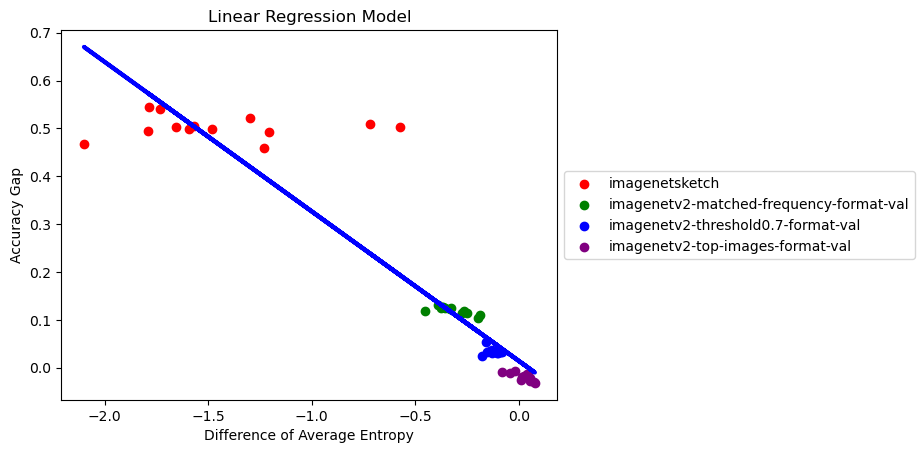

R2_score: 0.0
Pearson correlation coefficient: nan


/home/davidva/miniconda3/envs/anaconda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


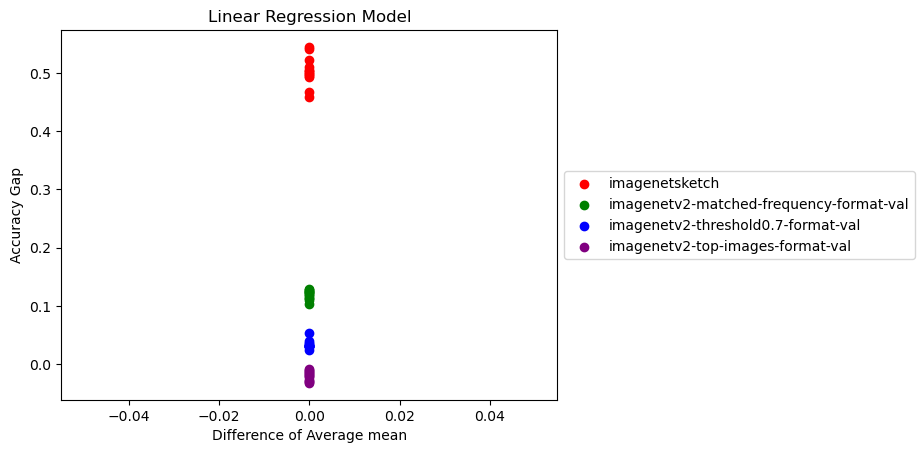

R2_score: 0.8254855038385022
Pearson correlation coefficient: 0.9085623279877402


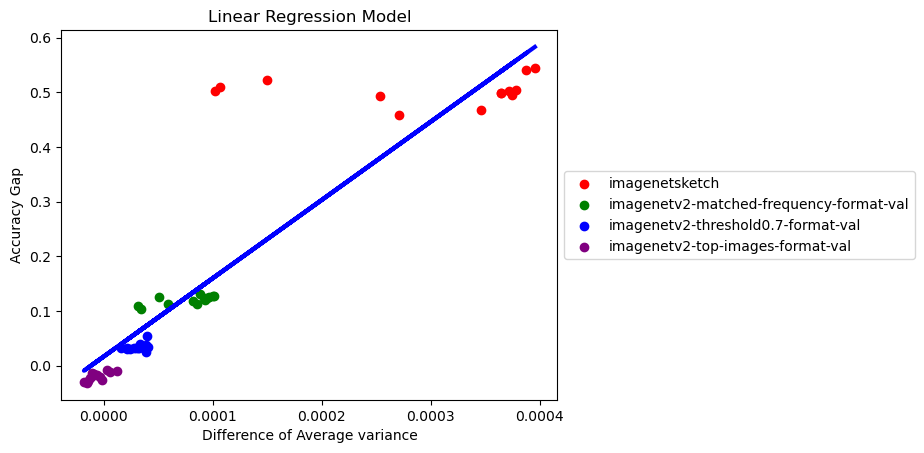

R2_score: 0.9551375584348518
Pearson correlation coefficient: 0.9773113927683702


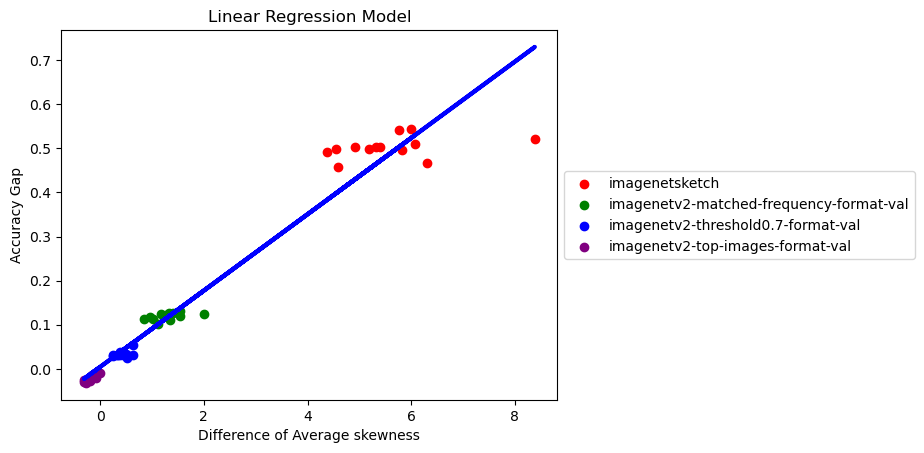

R2_score: 0.9726957107545755
Pearson correlation coefficient: 0.9862533704655085


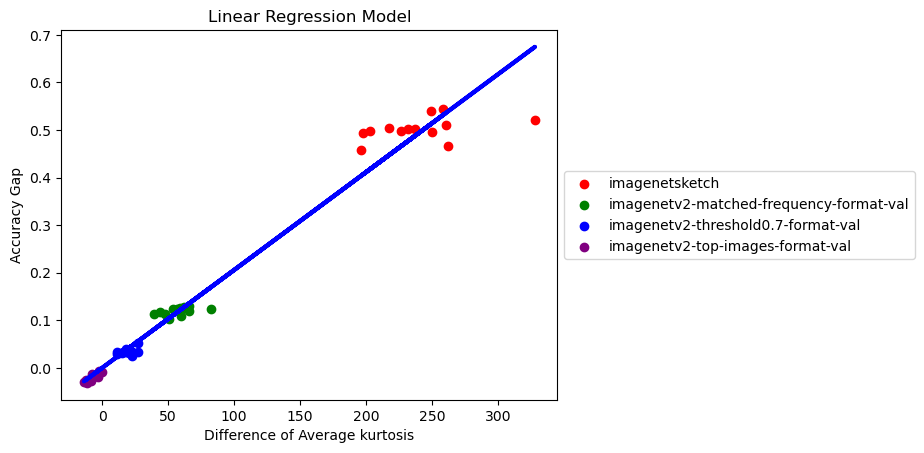

R2_score: 0.9890890481622616
Pearson correlation coefficient: -0.9945295612309679


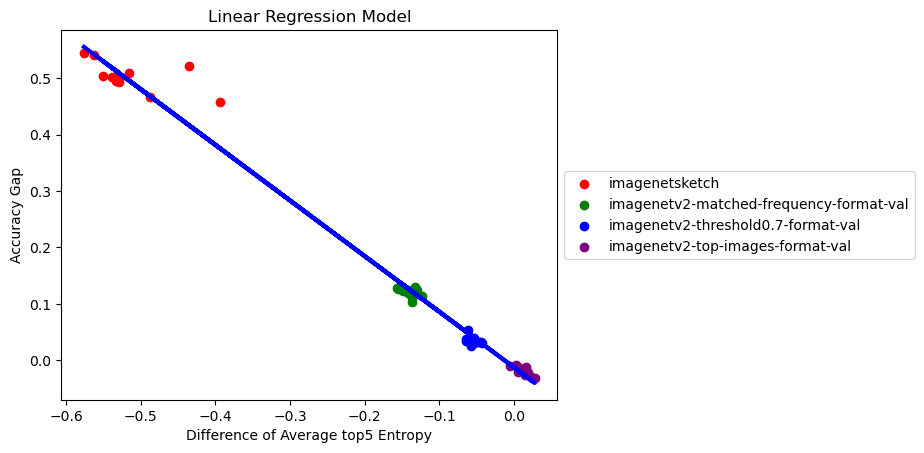

R2_score: 0.8899982311237556
Pearson correlation coefficient: 0.94339717570266


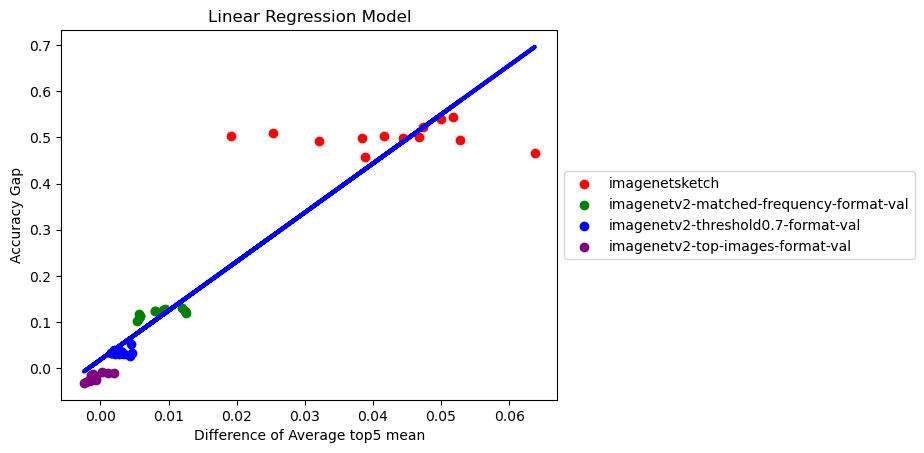

R2_score: 0.819742151087725
Pearson correlation coefficient: 0.9053961293752724


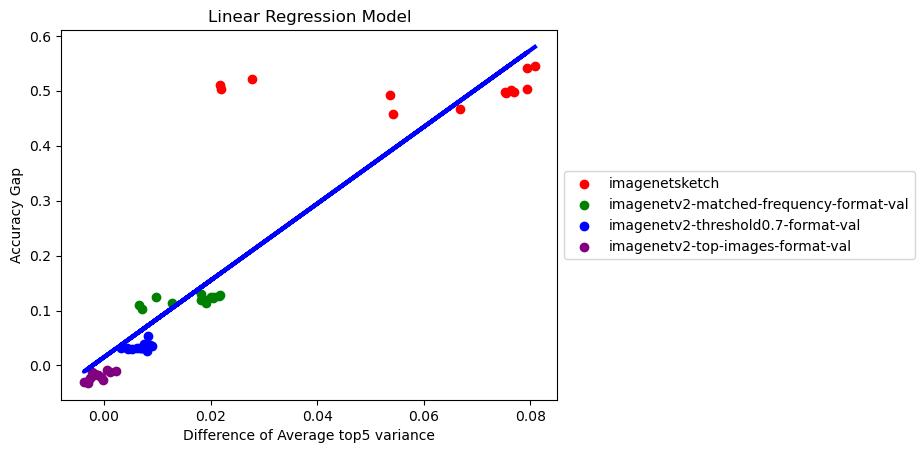

R2_score: 0.99244856944779
Pearson correlation coefficient: 0.9962171296699278


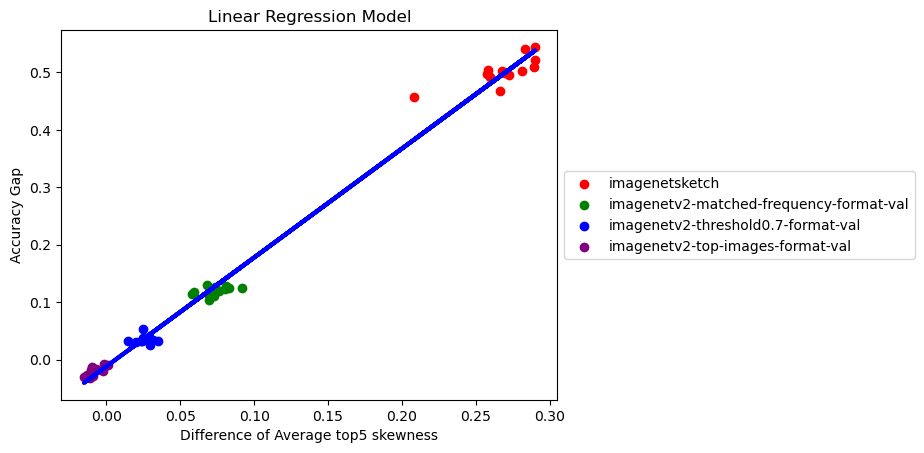

R2_score: 0.9915750824445506
Pearson correlation coefficient: 0.9957786312451931


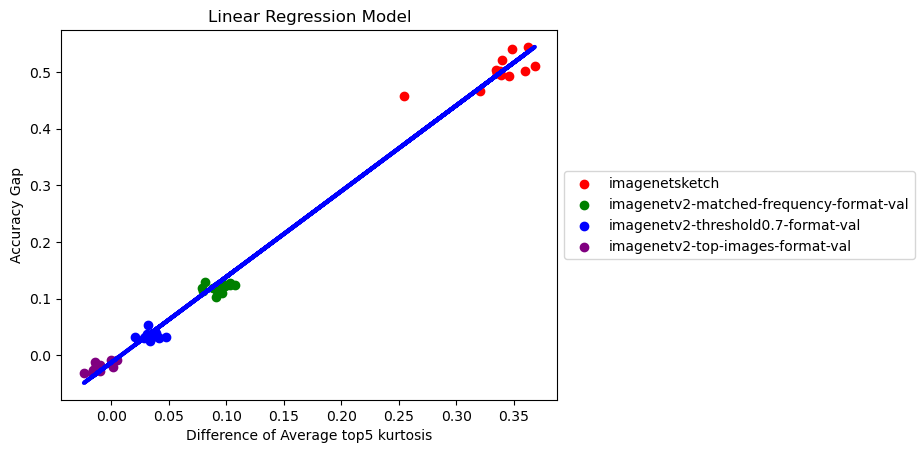

R2_score: 0.9245354859988125
Pearson correlation coefficient: 0.961527683428206


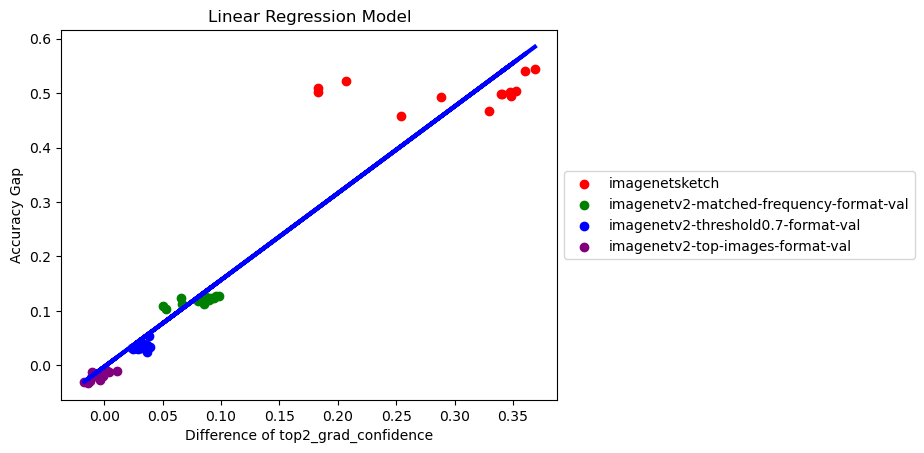

In [173]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy

df_original = df
df = df[df['Dataset'] != 'imagenet-a']
df = df[df['Dataset'] != 'imagenet-r']
datasets = df['Dataset'].unique()  # list of dataset names

# colors for the scatter plot. each dataset gets a different color
colors = ['red', 'green', 'blue', 'purple', 'orange', 'black', 'brown']

for column in df.columns[3:]:  # skipping the first three columns where there aren't any response vectors
    X = df[column].values.reshape(-1, 1)
    y = df['Accuracy'].values.reshape(-1, 1)
    nan_mask = np.isnan(X)  # used for the case of the kurtosis column where there are some rows without values
    if np.sum(nan_mask > 0):
        X = X[~nan_mask].reshape(-1, 1)
        y = y[~nan_mask].reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    
    R2_score = r2_score(y, y_pred)
    print('R2_score: ' + str(R2_score))
    pearson_correlation_coeff = scipy.stats.pearsonr(X.flatten(), y.flatten()).statistic
    print('Pearson correlation coefficient: ' + str(pearson_correlation_coeff))
    
    plt.plot(X, y_pred, color='blue', linewidth=3)
    
    for i, dataset in enumerate(datasets):
        X = df[df['Dataset'] == dataset][column].values.reshape(-1, 1)
        y = df[df['Dataset'] == dataset]['Accuracy'].values.reshape(-1, 1)
        plt.scatter(X, y, color=colors[i], label=dataset)
    
    plt.title('Linear Regression Model')
    plt.xlabel('Difference of ' + column)
    plt.ylabel('Accuracy Gap')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [ ]:
def main():
    # Define device, batch size and directory path for ImageNet validation set
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    base_exp_dir = '/home/davidva/experiments_David'
    
    # Set reproducibility variables
    seed = 42
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    np.random.seed(seed)
    
    # Define the batch size
    batch_size = 128

    # Load imagenet labels as real classes
    imagenet_labels = load_imagenet_labels()  # 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark'...

    # data_names = ['imagenet', 'imagenetv2-matched-frequency-format-val', 'imagenetv2-threshold0.7-format-val', 'imagenetv2-top-images-format-val', 'imagenetsketch/sketch', 'imagenet-r', 'imagenet-a']
    data_names = ['gaussian_noise', 'shot_noise', 'gaussian_blur', 'impulse_noise', 'frost', 'snow', 'fog', 'contrast', 'brightness', 'speckle_noise', 'spatter', 'saturate', 'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']

    for data_name in data_names:
        if data_name in ['imagenet', 'imagenetv2-matched-frequency-format-val', 'imagenetv2-threshold0.7-format-val', 'imagenetv2-top-images-format-val', 'imagenetsketch', 'gaussian_noise', 'shot_noise', 'gaussian_blur', 'impulse_noise', 'frost', 'snow', 'fog', 'contrast', 'brightness', 'speckle_noise', 'spatter', 'saturate', 'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']:
            ds_specific_mask = [True] * 1000
            ds_specific_labels = imagenet_labels  # the classes of the specific dataset that we're working with
        elif data_name == 'imagenet-r':
            ds_specific_mask = class_names.imagenet_r_mask
            ds_specific_labels = class_names.imagenet_r_labels
        elif data_name == 'imagenet-a':  # note: if the hidden file .ipynb_checkpoints is inside of the folder of the imagenet-a data,
                                         # it should be removed from there in order to create the DataFolder object
            ds_specific_mask = class_names.imagenet_a_mask
            ds_specific_labels = class_names.imagenet_a_labels

        if data_name == 'imagenet':
            val_dir = '/datasets/ImageNet/val/'
        elif data_name == 'imagenetsketch':
            val_dir = '/home/davidva/datasets/imagenetsketch/sketch'
        elif data_name in ['gaussian_noise', 'shot_noise', 'gaussian_blur', 'impulse_noise', 'frost', 'snow', 'fog', 'contrast', 'brightness', 'speckle_noise', 'spatter', 'saturate', 'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']:
            val_dir = '/home/davidva/datasets/' + data_name + '/5/'
        else:
            val_dir = '/home/davidva/datasets/' + data_name
        print('data_name is: ' + data_name + ' and val_dir is: ' + val_dir)
        
        model_names = ['resnet50', 'resnet18', 'resnet34', 'resnet101', 'resnet152', 'vgg16', 'vgg19', 'alexnet', 'resnext', 'wide_resnet', 'densenet121', 'googlenet', 'mobilenet_v2']
    
        for model_name in model_names:
            if model_name in ['resnet50', 'resnet18'] and data_name == 'contrast':
                continue
            # Experiment name
            curr_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
            exp_base_name = 'predict_' + data_name + '5_' + model_name
            exp_name = exp_base_name + '_' + curr_time
            exp_dir = os.path.join(base_exp_dir, exp_name)
            results_dir = os.path.join(exp_dir, 'results')
            embed_dir = os.path.join(results_dir, 'val_embeddings')
        
            # Create experiment directory
            os.makedirs(exp_dir, exist_ok=True)
            os.makedirs(results_dir, exist_ok=True)
            os.makedirs(embed_dir, exist_ok=True)
                
            # Load the ImageNet validation dataset with defined transformations
            val_dataset = ImageFolder(val_dir, transform=preprocess_images_any_dataset(model_name))
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=5)
    
            # Load model
            model = load_model(model_name).to(device)
            model.eval()
            
            # Register the hook at the penultimate layer of the model
            if model_name in ['mobilenet_v2']:
                layer = model.classifier[0]
            elif model_name in ['densenet121']:
                layer = model.features  # model.features.norm5 sucks, features.denseblock3.denselayer24 is okay, features gives 1000-of-shape output, model.features.denseblock3.denselayer24.conv2 is okay
            elif model_name in ['vgg16', 'vgg19']:
                layer = model.classifier[-2]
            else:
                layer = model.avgpool
            
            # Prepare DataFrame to store results
            results = []
            total_correct = 0
            batch_num = 0
            all_entropies = np.empty([0])
            all_means = np.empty([0])
            all_variances = np.empty([0])
            all_skewnesses = np.empty([0])
            all_kurtosises = np.empty([0])
            all_top5_entropies = np.empty([0])
            all_top5_means = np.empty([0])
            all_top5_variances = np.empty([0])
            all_top5_skewnesses = np.empty([0])
            all_top5_kurtosises = np.empty([0])
    
            # Disable gradients for faster inference
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(tqdm(val_loader, desc=f"Processing {exp_name}")):
                    images = images.to(device)
                    labels = labels.to(device)
    
                    # handle = layer.register_forward_hook(get_embedding_hook(batch_idx, batch_size, embed_dir))
    
                    # Run forward pass through the model
                    output = model(images)

                    # Create a tensor of the mask on the device
                    mask_tensor = torch.tensor(ds_specific_mask).to(device)

                    # Replace masked values in the output with negative infinity
                    if data_name in ['imagenet-a', 'imagenet-r', 'imagenet_vid_robust']:
                        output[:, ~mask_tensor] = float('-inf')

                    # Apply softmax
                    probabilities = torch.nn.functional.softmax(output, dim=1)

                    # Get top-5 predictions and confidences and some statistics
                    top5_prob, top5_classes = torch.topk(probabilities, 5)
                    _, _, top5_means, top5_variances, top5_skewnesses, top5_kurtosises = scipy.stats.describe(top5_prob.detach().cpu().numpy() , axis=1)
                    all_top5_means = np.concatenate((all_top5_means, top5_means))
                    all_top5_variances = np.concatenate((all_top5_variances, top5_variances))
                    all_top5_skewnesses = np.concatenate((all_top5_skewnesses, top5_skewnesses))
                    all_top5_kurtosises = np.concatenate((all_top5_kurtosises, top5_kurtosises))
                    top5_entropies = scipy.stats.entropy(top5_prob.detach().cpu().numpy(), axis=1)
                    all_top5_entropies = np.concatenate((all_top5_entropies, top5_entropies))
                    
                    _, _, means, variances, skewnesses, kurtosises = scipy.stats.describe(probabilities.detach().cpu().numpy() , axis=1)
                    all_means = np.concatenate((all_means, means))
                    all_variances = np.concatenate((all_variances, variances))
                    all_skewnesses = np.concatenate((all_skewnesses, skewnesses))
                    all_kurtosises = np.concatenate((all_kurtosises, kurtosises))
                    entropies = scipy.stats.entropy(probabilities.detach().cpu().numpy(), axis=1)
                    all_entropies = np.concatenate((all_entropies, entropies))
        
                    # Iterate over each image in the batch
                    for i in range(len(images)):
                        image_idx = batch_idx * batch_size + i
                        image_path = val_dataset.imgs[i + batch_num * batch_size][0]
                        # true_class = val_dataset.classes[labels[i].item()]
                        true_class = ds_specific_labels[labels[i].item()]  # e.g. labels[i].item()=0. true_class=goldfish
                        predictions = {"image_path": image_path,
                                       "true_class": true_class,
                                       "embeddings_path":  os.path.join(embed_dir, f"{image_idx}_embeddings.npy")}
                        
                        for j in range(5):
                            # predictions[f"top{j+1}_prediction_class"] = val_dataset.classes[top5_classes[i, j].item()]
                            prediction_class = imagenet_labels[top5_classes[i, j].item()]
                            predictions[f"top{j+1}_prediction_class"] = prediction_class
                            predictions[f"top{j+1}_confidence"] = top5_prob[i, j].item()
        
                            # Check if top-1 prediction is correct
                            if j == 0 and prediction_class == true_class:
                                total_correct += 1
                        results.append(predictions)
                    batch_num += 1
                    # handle.remove()  # Unregister the hook after processing the batch
            
            # Convert results to DataFrame and save to CSV
            results_df = pd.DataFrame(results)
            results_df.to_csv(os.path.join(results_dir, f"full_val_predictions_{exp_base_name}.csv"), index=False)
        
            # Calculate average and std of the top1 confidences across the val set2
            avg_confidence = results_df["top1_confidence"].mean()
            std_confidence = results_df["top1_confidence"].std()
            accuracy = total_correct / len(val_dataset)
            average_top5_mean = np.mean(all_top5_means)
            average_top5_variance = np.mean(all_top5_variances)
            average_top5_skewness = np.mean(all_top5_skewnesses)
            average_top5_kurtosis = np.mean(all_top5_kurtosises)
            average_top5_entropy = np.mean(all_top5_entropies)
            average_mean = np.mean(all_means)
            average_variance = np.mean(all_variances)
            average_skewness = np.mean(all_skewnesses)
            average_kurtosis = np.mean(all_kurtosises)
            average_entropy = np.mean(all_entropies)
            top2_grad_confidence = (results_df["top1_confidence"] - results_df["top2_confidence"]).mean()
    
            # Save average and std confidences in a new DataFrame and some more statistics
            confidence_df = pd.DataFrame({
                "Accuracy": [accuracy],
                "Average Confidence": [avg_confidence],
                "Standard Deviation Confidence": [std_confidence],
                "Average Entropy": [average_entropy],
                "Average mean": [average_mean],
                "Average variance": [average_variance],
                "Average skewness": [average_skewness],
                "Average kurtosis": [average_kurtosis],
                "Average top5 Entropy": [average_top5_entropy],
                "Average top5 mean": [average_top5_mean],
                "Average top5 variance": [average_top5_variance],
                "Average top5 skewness": [average_top5_skewness],
                "Average top5 kurtosis": [average_top5_kurtosis],
                "top2_grad_confidence": [top2_grad_confidence]
            })
            confidence_df.to_csv(os.path.join(results_dir, f"val_confidence_summary_{exp_base_name}.csv"), index=False)
    
            # # Handle embeddings
            # embeddings = np.array([np.load(file) for file in results_df['embeddings_path']])
            # # assuming embeddings is a 4D numpy array
            # embeddings = embeddings.reshape(embeddings.shape[0], -1)
            # average, covariance = calculate_activation_statistics(embeddings)
            # np.save(os.path.join(results_dir, 'embeddings_covariance.npy'), covariance)
            # np.save(os.path.join(results_dir, 'embeddings_average.npy'), average)
            # # np.save(os.path.join(results_dir, 'tot_embeddings_2D_np_array.npy'), embeddings)
            
            # Create a new DataFrame for embeddings
            # df_embeddings = pd.DataFrame(*******, columns=np.arange(0, embeddings.shape[1]))
            # df_embeddings['true_class'] = results_df['true_class']
            # df_embeddings['predicted_class'] = results_df['top1_prediction_class']
            # df_embeddings['image_path'] = results_df['image_path']
            # # Save as CSV
            # df_embeddings.to_csv(os.path.join(results_dir, f"val_embeddings_2d_{exp_base_name}.csv"), index=False)
            
            
if __name__ == '__main__':
    main()

In [10]:
import os

folder_path = "/home/davidva/experiments_David"

data_names = ['gaussian_noise', 'shot_noise', 'gaussian_blur', 'impulse_noise', 'speckle_noise', 'elastic_transform', 'jpeg_compression', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']

for data_name in data_names:
    for folder_name in os.listdir(folder_path):
        if data_name in folder_name:
            new_folder_name = folder_name.replace(data_name, data_name.replace("_", "-"))
            os.rename(os.path.join(folder_path, folder_name), os.path.join(folder_path, new_folder_name))

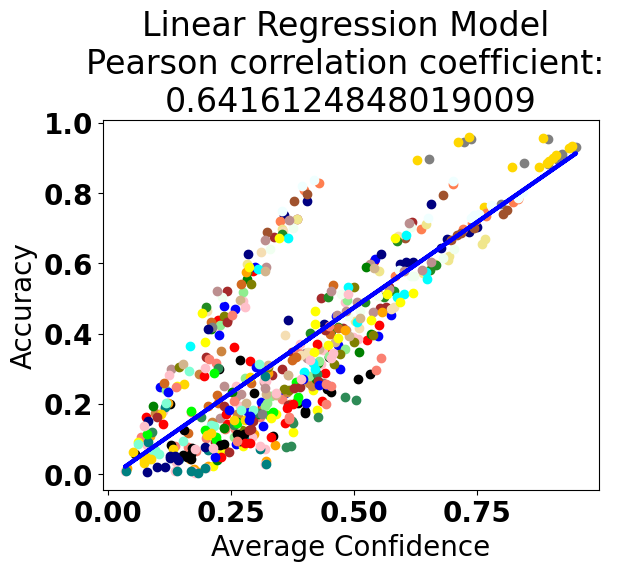

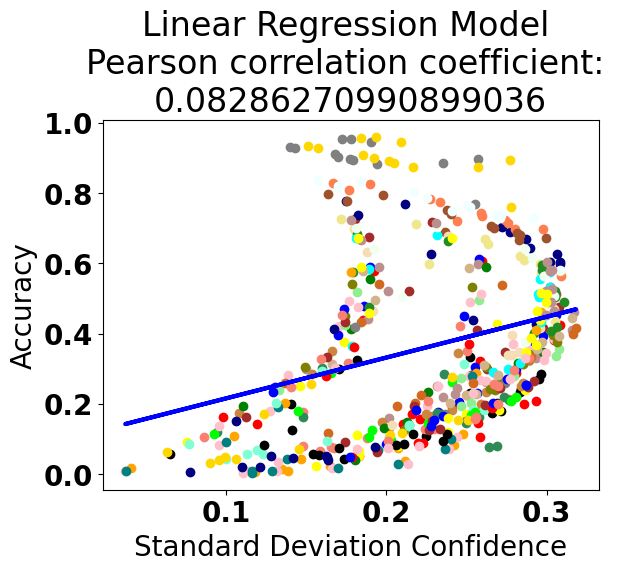

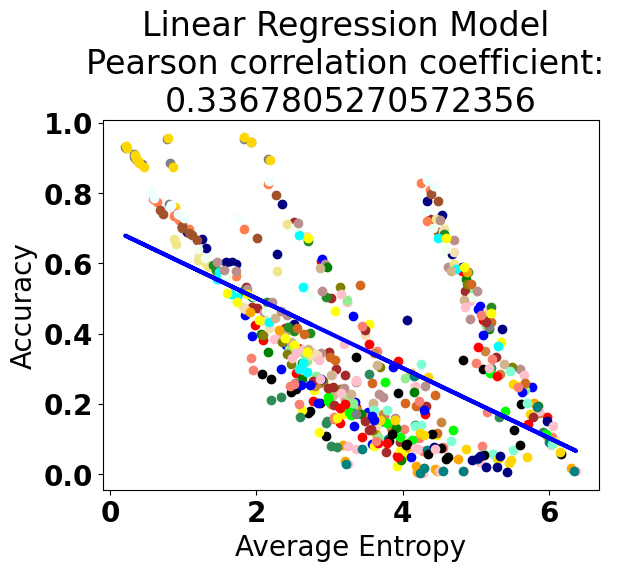

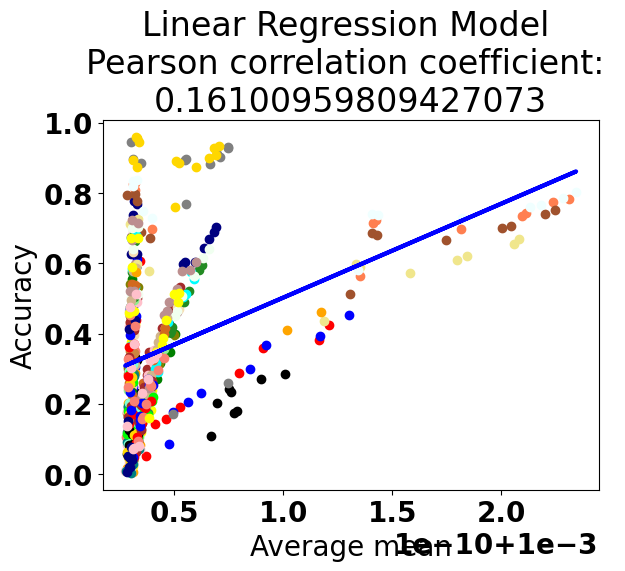

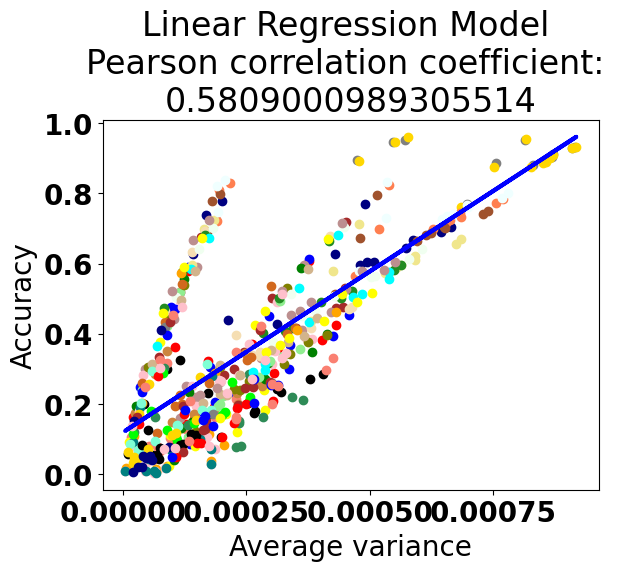

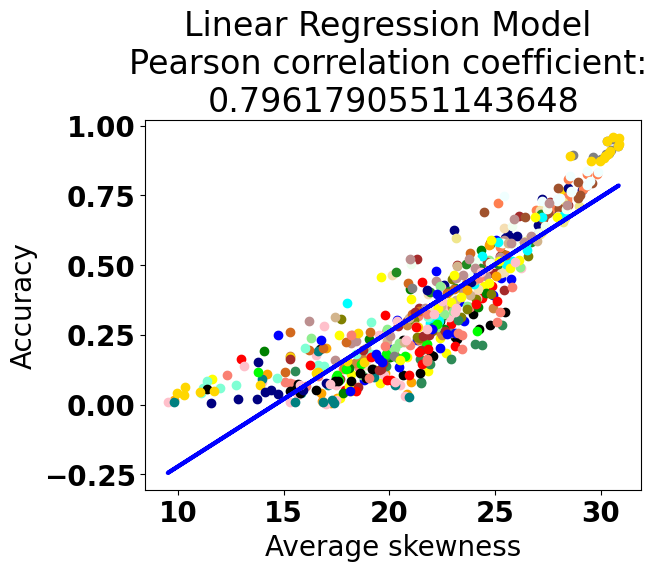

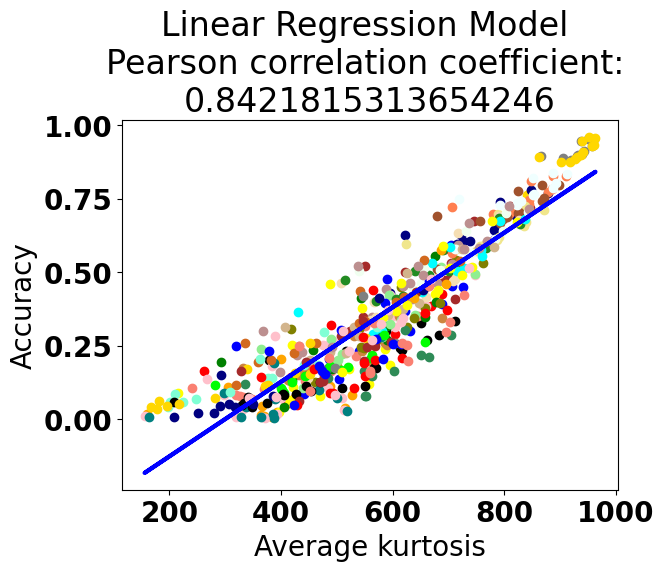

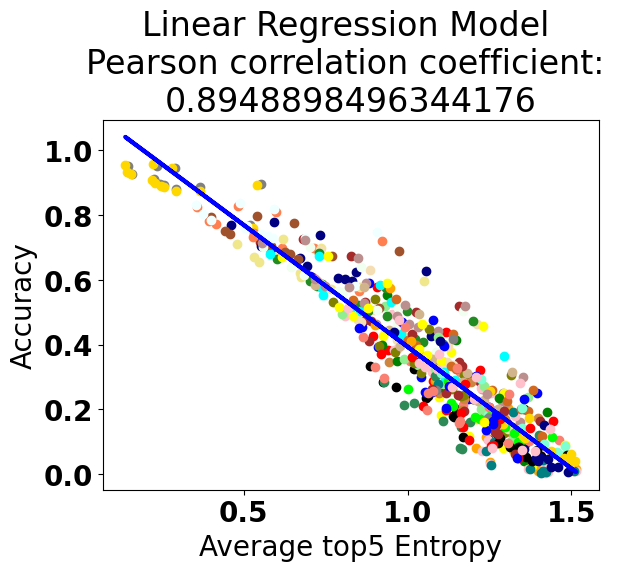

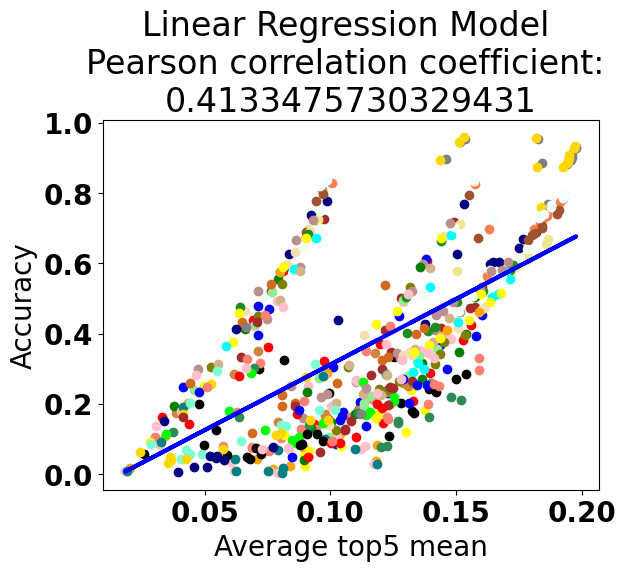

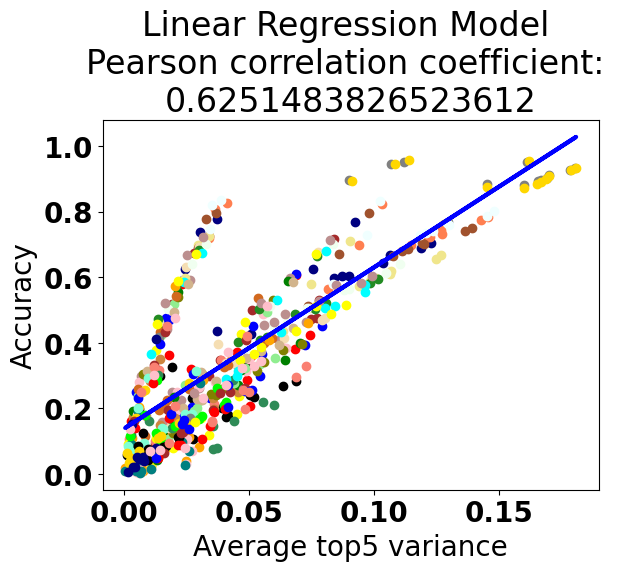

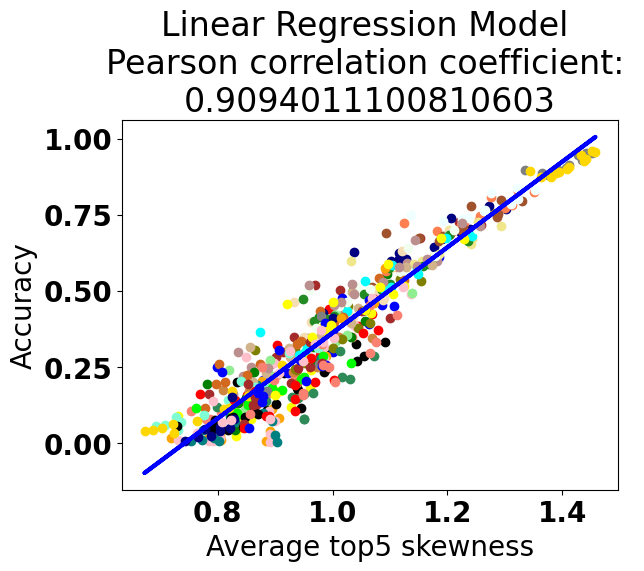

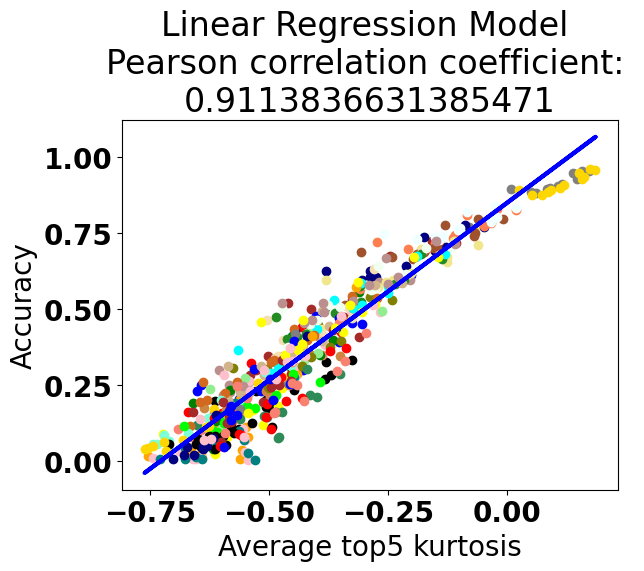

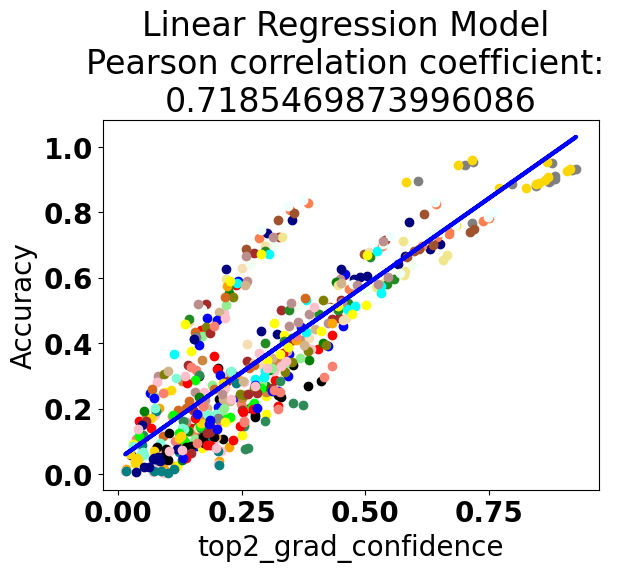

In [45]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy
import matplotlib

df = pd.read_csv('all_experiments_including_imagenet_c.csv')
datasets = df['Dataset'].unique()  # list of dataset names

# colors for the scatter plot. each dataset gets a different color
colors = ['black', 'grey', 'gold', 'brown', 'red', 'blue', 'navy', 'orange', 'rosybrown', 'salmon', 'yellow', 'pink', 'peru', 'green', 'pink', 'lightgreen', 'olive', 'coral', 'khaki', 'sienna', 'azure', 'wheat', 'forestgreen', 'seagreen', 'cyan', 'teal', 'honeydew', 'tan', 'chocolate', 'aquamarine', 'lime', 'black', 'grey', 'gold', 'brown', 'red', 'blue', 'navy', 'orange', 'rosybrown', 'salmon', 'yellow', 'pink', 'peru', 'green', 'pink', 'lightgreen', 'olive', 'coral', 'khaki', 'sienna', 'azure', 'wheat', 'forestgreen', 'seagreen', 'cyan', 'teal', 'honeydew', 'tan', 'chocolate', 'aquamarine', 'lime']

font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

for column in df.columns[3:]:  # skipping the first three columns where there aren't any response vectors
    X = df[column].values.reshape(-1, 1)
    y = df['Accuracy'].values.reshape(-1, 1)
    nan_mask = np.isnan(X)  # used for the case of the kurtosis column where there are some rows without values
    if np.sum(nan_mask > 0):
        X = X[~nan_mask].reshape(-1, 1)
        y = y[~nan_mask].reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    
    R2_score = r2_score(y, y_pred)
    # print('R2_score: ' + str(R2_score))
    pearson_correlation_coeff = scipy.stats.pearsonr(X.flatten(), y.flatten()).statistic
    # print('Pearson correlation coefficient: ' + str(pearson_correlation_coeff))
    
    plt.plot(X, y_pred, color='blue', linewidth=3)
    
    for i, dataset in enumerate(datasets):
        X = df[df['Dataset'] == dataset][column].values.reshape(-1, 1)
        y = df[df['Dataset'] == dataset]['Accuracy'].values.reshape(-1, 1)
        plt.scatter(X, y, color=colors[i], label=dataset)
    
    plt.title('Linear Regression Model \n' + 'Pearson correlation coefficient: \n' + str(R2_score))
    plt.xlabel(column)
    plt.ylabel('Accuracy')
    
    plt.show()

In [50]:
df = pd.read_csv('all_experiments_including_imagenet_c.csv')
datasets = df['Dataset'].unique()  # list of dataset names
models = df['Model'].unique()  # list of dataset names

for dataset in datasets:
    if dataset in ['imagenet', 'imagenet_with_labels_of_imagenet-r', 'imagenet_with_labels_of_imagenet-a']:
        continue
    for model in models:
        for i, col in enumerate(list(df.columns[2:])):
            shifted_col = i + 2
            ID_dataset_name = 'imagenet_with_labels_of_' + dataset if dataset in ['imagenet_with_labels_of_imagenet-r', 'imagenet_with_labels_of_imagenet-a'] else 'imagenet'
            # the line of the data of a specific OOD dataset and a specific model
            ID_value = df[(df['Dataset'] == ID_dataset_name) & (df['Model'] == model)].iloc[:, shifted_col].to_numpy()
            # the line of the data of a imagenet and a specific model
            OOD_value = df[(df['Dataset'] == dataset) & (df['Model'] == model)].iloc[:, shifted_col].to_numpy()
            # subtracting between the lines
            diff = ID_value - OOD_value
            # assigning the values to the line of OOD dataset
            df.loc[(df['Dataset'] == dataset) & (df['Model'] == model), df.columns[shifted_col]] = diff
df = df[(df['Dataset'] != 'imagenet') & (df['Dataset'] != 'imagenet_with_labels_of_imagenet-a') & (df['Dataset'] != 'imagenet_with_labels_of_imagenet-r')]

df.to_csv(path_or_buf = "all_experiments_including_imagenet_c_differences.csv")

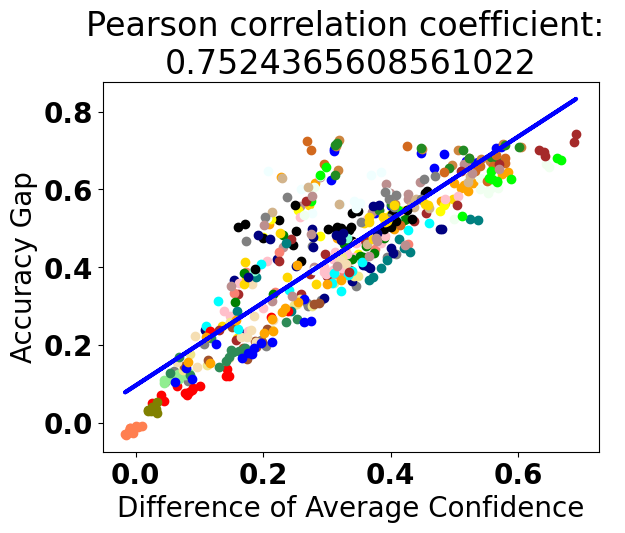

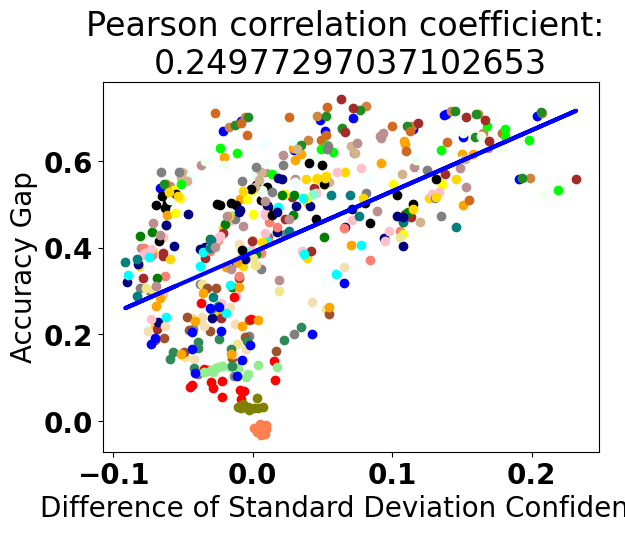

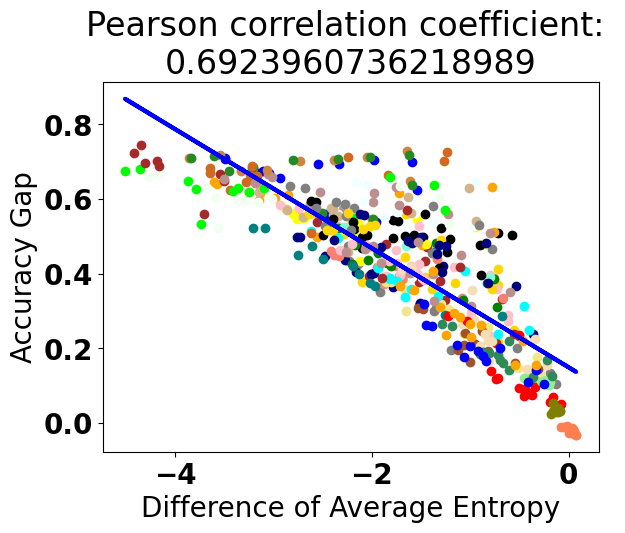

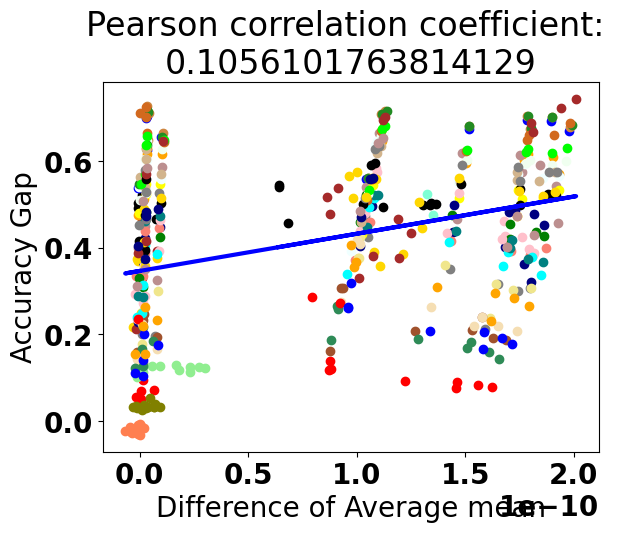

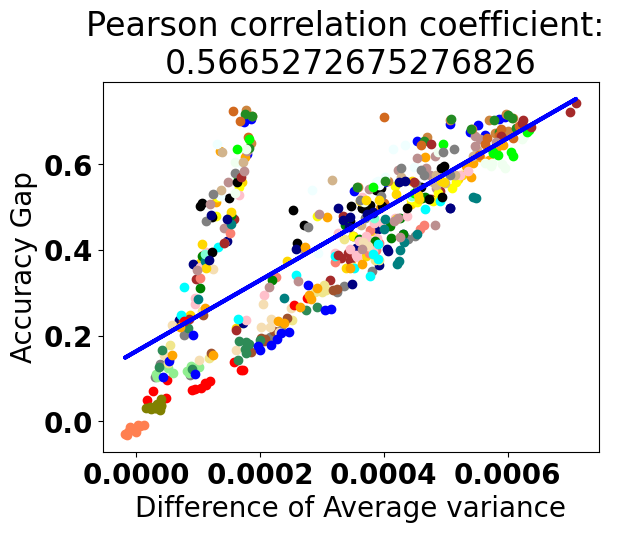

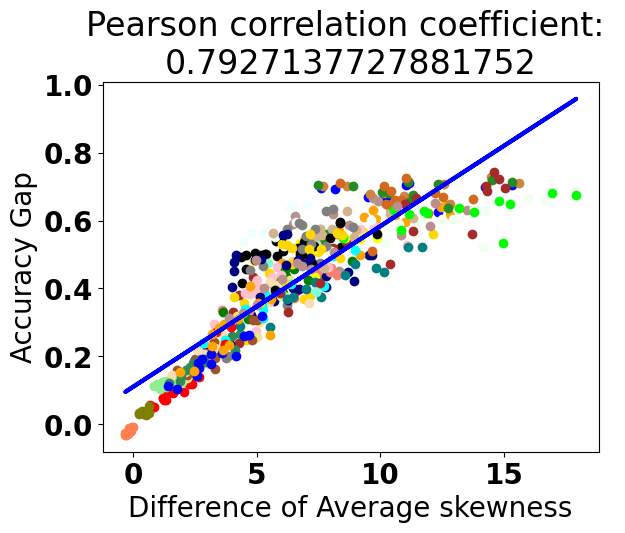

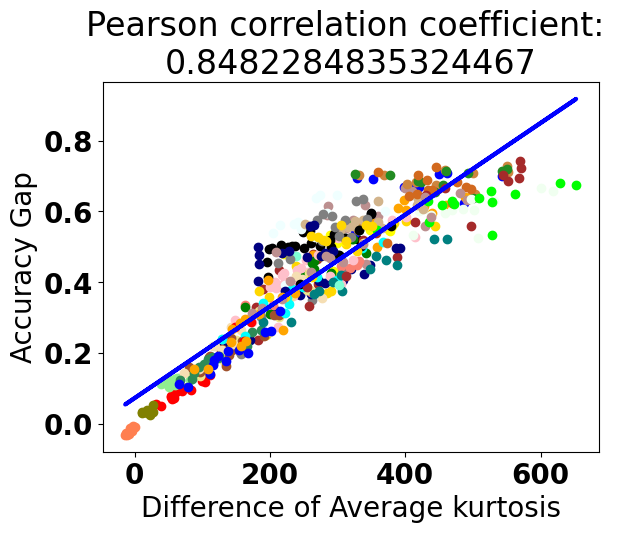

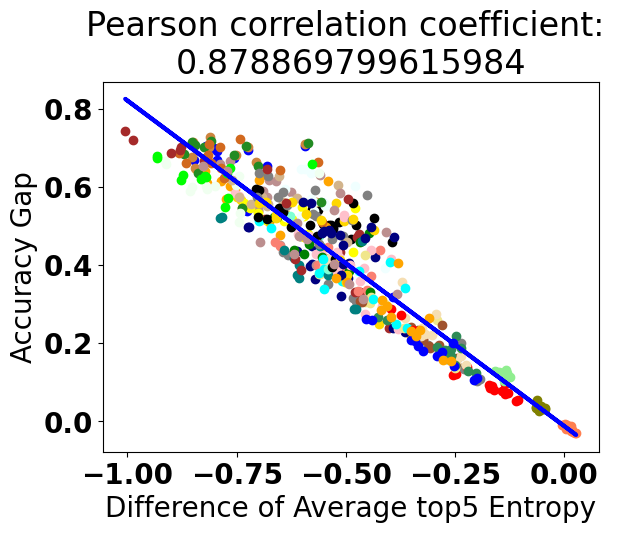

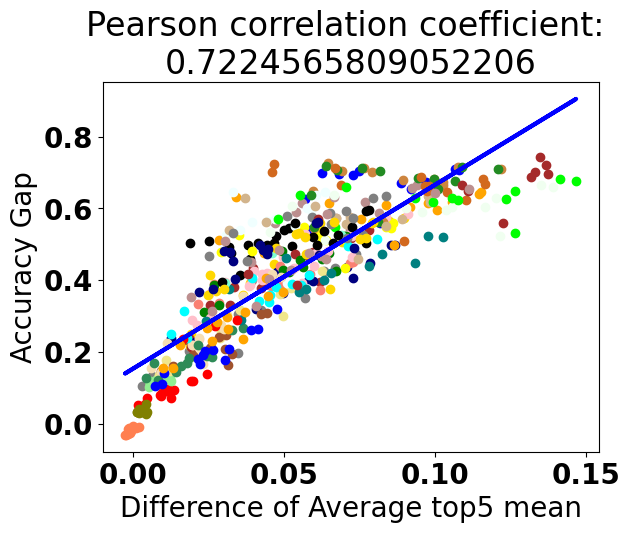

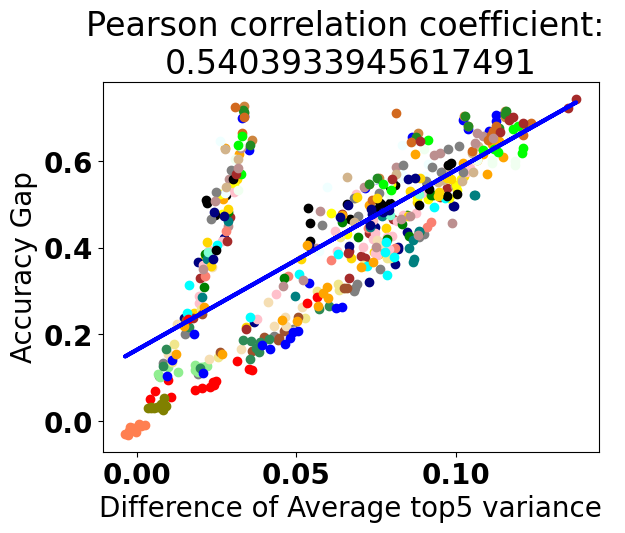

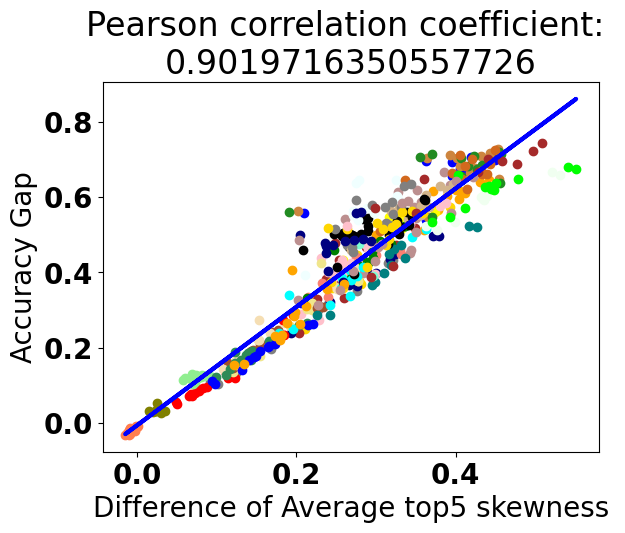

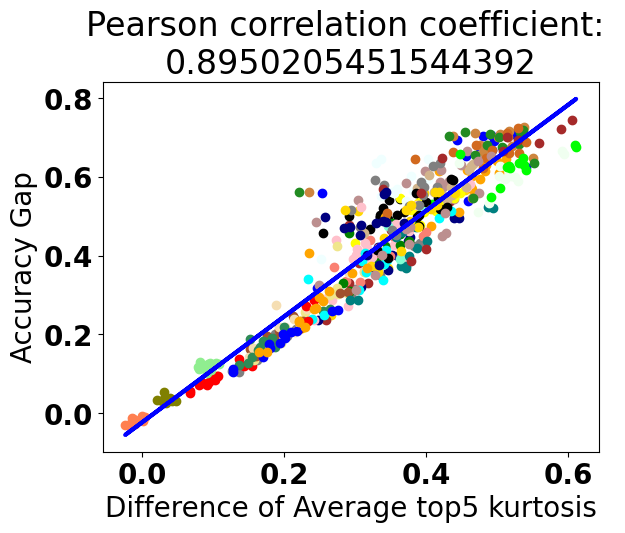

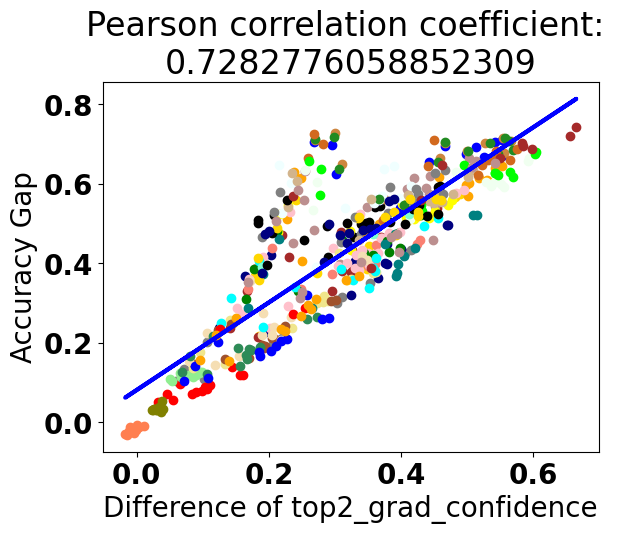

In [51]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy

df_original = df
df = df[df['Dataset'] != 'imagenet-a']
df = df[df['Dataset'] != 'imagenet-r']
datasets = df['Dataset'].unique()  # list of dataset names

font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 20}

# colors for the scatter plot. each dataset gets a different color
colors = ['black', 'grey', 'gold', 'brown', 'red', 'blue', 'navy', 'orange', 'rosybrown', 'salmon', 'yellow', 'pink', 'peru', 'green', 'pink', 'lightgreen', 'olive', 'coral', 'khaki', 'sienna', 'azure', 'wheat', 'forestgreen', 'seagreen', 'cyan', 'teal', 'honeydew', 'tan', 'chocolate', 'aquamarine', 'lime', 'black', 'grey', 'gold', 'brown', 'red', 'blue', 'navy', 'orange', 'rosybrown', 'salmon', 'yellow', 'pink', 'peru', 'green', 'pink', 'lightgreen', 'olive', 'coral', 'khaki', 'sienna', 'azure', 'wheat', 'forestgreen', 'seagreen', 'cyan', 'teal', 'honeydew', 'tan', 'chocolate', 'aquamarine', 'lime']

for column in df.columns[3:]:  # skipping the first three columns where there aren't any response vectors
    X = df[column].values.reshape(-1, 1)
    y = df['Accuracy'].values.reshape(-1, 1)
    nan_mask = np.isnan(X)  # used for the case of the kurtosis column where there are some rows without values
    if np.sum(nan_mask > 0):
        X = X[~nan_mask].reshape(-1, 1)
        y = y[~nan_mask].reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    
    R2_score = r2_score(y, y_pred)
    # print('R2_score: ' + str(R2_score))
    pearson_correlation_coeff = scipy.stats.pearsonr(X.flatten(), y.flatten()).statistic
    # print('Pearson correlation coefficient: ' + str(pearson_correlation_coeff))
    
    plt.plot(X, y_pred, color='blue', linewidth=3)
    
    for i, dataset in enumerate(datasets):
        X = df[df['Dataset'] == dataset][column].values.reshape(-1, 1)
        y = df[df['Dataset'] == dataset]['Accuracy'].values.reshape(-1, 1)
        plt.scatter(X, y, color=colors[i], label=dataset)
    
    plt.title('Pearson correlation coefficient: \n' + str(R2_score))
    plt.xlabel('Difference of ' + column)
    plt.ylabel('Accuracy Gap')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [48]:
maximum = 0
for column in df.columns[3:]:  # skipping the first three columns where there aren't any response vectors
    for column2 in df.columns[3:]:  # skipping the first three columns where there aren't any response vectors
        if column == column2:
            continue
        X = df[[column, column2]].values
        y = df['Accuracy'].values.reshape(-1, 1)
        nan_mask = np.isnan(X)  # used for the case of the kurtosis column where there are some rows without values
        if np.sum(nan_mask > 0):
            X = X[~nan_mask].reshape(-1, 1)
            y = y[~nan_mask].reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        y_pred = reg.predict(X)
        
        R2_score = r2_score(y, y_pred)
        if maximum > R2_score:
            maximum = maximum
        else:
            maximum = R2_score
            best = [column, column2]
        # print('R2_score: ' + str(R2_score))
        # pearson_correlation_coeff = scipy.stats.pearsonr(X, y.flatten()).statistic
        print(R2_score, column, column2)
print(maximum, best)

0.6919894029497894 Average Confidence Standard Deviation Confidence
0.903636115741554 Average Confidence Average Entropy
0.648772438397266 Average Confidence Average mean
0.6748373149856255 Average Confidence Average variance
0.7967144097395774 Average Confidence Average skewness
0.8439236727981464 Average Confidence Average kurtosis
0.9193478275467593 Average Confidence Average top5 Entropy
0.8342489397439169 Average Confidence Average top5 mean
0.6422485178413484 Average Confidence Average top5 variance
0.9151193589286162 Average Confidence Average top5 skewness
0.916305218347564 Average Confidence Average top5 kurtosis
0.7942547734287961 Average Confidence top2_grad_confidence
0.6919894029497895 Standard Deviation Confidence Average Confidence
0.3735218150553069 Standard Deviation Confidence Average Entropy
0.18931321125418454 Standard Deviation Confidence Average mean
0.5988573104168158 Standard Deviation Confidence Average variance
0.8486743853591141 Standard Deviation Confidence 

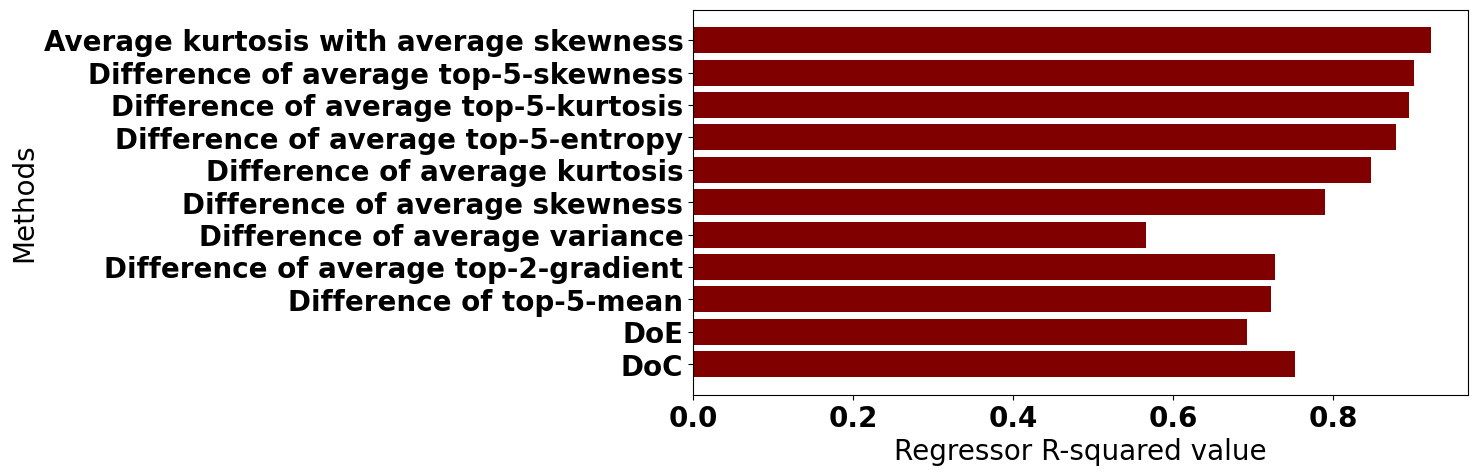

In [58]:
data = {'DoC': 0.752, 'DoE': 0.692, 'Difference of top-5-mean': 0.722, 'Difference of average top-2-gradient': 0.728, 'Difference of average variance': 0.566, 'Difference of average skewness': 0.79, 'Difference of average kurtosis': 0.848, 'Difference of average top-5-entropy': 0.879, 'Difference of average top-5-kurtosis': 0.895, 'Difference of average top-5-skewness': 0.902, 'Average kurtosis with average skewness': 0.923}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.barh(courses, values, color ='maroon')
 
plt.ylabel("Methods")
plt.xlabel("Regressor R-squared value")
plt.show()